# Projet 8 - Proof Of Concept - Modèle Phi3 Mini 4K - Microsoft

In [6]:
#imports divers

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from PIL import Image
import matplotlib.pyplot as plt
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition
from sklearn import manifold
import time
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
from gensim.models import Word2Vec
import tensorflow_hub as hub
from transformers import BertTokenizer, BertModel
import torch
from collections import Counter





# Télécharger les ressources nécessaires
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')


2024-07-20 10:28:38.297805: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-20 10:28:39.329456: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/alexandre/anaconda3/envs/stabadenvP6/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexandre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexandre/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[

True

## Préparation du dataset

In [7]:
#import du fichier dans un dataframe pandas
data_text = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")

In [8]:
#etude des colonnes du dataset
data_text.columns


Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [9]:
# visualisation des colonnes intéressantes
data_text[['product_category_tree', 'description']]

,product_category_tree,description
0,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...
1,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...
2,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...
3,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...
4,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...
...,...,...
1045,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Oren Empower Extra Large Self Adhesive Sticker...
1046,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Wallmantra Medium Vinyl Sticker Sticker fo...


In [10]:
# extraction de la catégorie du produit
data_text['label'] = data_text['product_category_tree'].str.extract(r'\[\"(.*?)>>', expand=False)

In [11]:
#compte du nombre de modalités et effectifs correspondant
data_text['label'].value_counts()

label
Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: count, dtype: int64

In [12]:
#variante 
data_text.groupby("label").count()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
label,,,,,,,,,,,,,,,
Baby Care,150,150,150,150,150,150,149,149,150,150,150,150,150,134,150
Beauty and Personal Care,150,150,150,150,150,150,150,150,150,150,150,150,150,41,150
Computers,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
Home Decor & Festive Needs,150,150,150,150,150,150,150,150,150,150,150,150,150,148,149
Home Furnishing,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
Kitchen & Dining,150,150,150,150,150,150,150,150,150,150,150,150,150,79,150
Watches,150,150,150,150,150,150,150,150,150,150,150,150,150,10,150


In [13]:
#sélection des colonnes intéressantes
data_text = data_text[['product_name', 'image', 'description', 'label']]

In [14]:
data_text

,product_name,image,description,label
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing
...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care
1046,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Baby Care
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Baby Care
1048,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Baby Care


### Encodage labels

In [15]:
# Encoder les labels
label_encoder = LabelEncoder()
data_text['label_encoded'] = label_encoder.fit_transform(data_text['label'])

# Afficher les correspondances des valeurs
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Correspondance des valeurs :")
print(label_mapping)

Correspondance des valeurs :
{'Baby Care ': 0, 'Beauty and Personal Care ': 1, 'Computers ': 2, 'Home Decor & Festive Needs ': 3, 'Home Furnishing ': 4, 'Kitchen & Dining ': 5, 'Watches ': 6}


In [16]:
data_text

,product_name,image,description,label,label_encoded
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,0
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,4
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,4
...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care,0
1046,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Baby Care,0
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Baby Care,0
1048,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Baby Care,0


### Nettoyage du texte

In [17]:
# Initialiser le lemmatizer
lemmatizer = WordNetLemmatizer()

# Définir la fonction de prétraitement
def preprocess_text(text):
    # Nettoyage du texte, tokenisation, suppression des stopwords, lemmatisation, etc.
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word.lower() for word in tokens if word not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# Appliquer la fonction de prétraitement à la colonne 'description'
data_text['tokens'] = data_text['description'].dropna().apply(preprocess_text)

# Créer un compteur de fréquence des mots
#all_tokens = [token for tokens in data_text['tokens'] for token in tokens]
#token_counts = Counter(all_tokens)

# Définir une fonction pour enlever les mots fréquents et rares
def remove_frequent_rare(tokens, min_freq=2, max_freq_ratio=0.9):
    total_tokens = len(all_tokens)
    max_freq = max_freq_ratio * total_tokens
    return [token for token in tokens if min_freq <= token_counts[token] <= max_freq]

# Appliquer la fonction pour enlever les mots fréquents et rares
#data_text['tokens'] = data_text['tokens'].apply(lambda tokens: remove_frequent_rare(tokens))

# Afficher un échantillon pour vérifier le résultat
print(data_text[['description', 'tokens']].head())

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                                              tokens  
0  [key, feature, elegance, polyester, multicolor...  
1  [specification, sathiyas, cotton, bath, towel,...  
2  [key, feature, eurospa, cotton, terry, face, t...  
3  [key, feature, santosh, royal, fashion, cotton...  
4  [key, feature, jaipur, print, cotton, floral, ...  


In [18]:
data_text['tokens']

0       [key, feature, elegance, polyester, multicolor...
1       [specification, sathiyas, cotton, bath, towel,...
2       [key, feature, eurospa, cotton, terry, face, t...
3       [key, feature, santosh, royal, fashion, cotton...
4       [key, feature, jaipur, print, cotton, floral, ...
                              ...                        
1045    [oren, empower, extra, large, self, adhesive, ...
1046    [wallmantra, large, vinyl, sticker, sticker, p...
1047    [buy, uberlyfe, extra, large, pigmented, polyv...
1048    [buy, wallmantra, medium, vinyl, sticker, stic...
1049    [buy, uberlyfe, large, vinyl, sticker, online,...
Name: tokens, Length: 1050, dtype: object

### Analyse rapide des traitements appliqués

In [19]:
data_text.columns

Index(['product_name', 'image', 'description', 'label', 'label_encoded',
       'tokens'],
      dtype='object')

## Preparation données pour Phi 3

### Import bib et chargement modèle

In [50]:
from llama_cpp import Llama

# Chemin vers le fichier modèle GGUF
model_path = "./Phi-3-mini-4k-instruct-q4.gguf"

# Initialisation du modèle
llm = Llama(
  model_path=model_path,
  n_ctx=4096,  # Longueur maximale de la séquence
  n_threads=8, # Nombre de threads CPU à utiliser
  n_gpu_layers=0 # Nombre de couches à décharger sur GPU, mettre 0 si pas de GPU
)


llama_model_loader: loaded meta data with 24 key-value pairs and 195 tensors from ./Phi-3-mini-4k-instruct-q4.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = phi3
llama_model_loader: - kv   1:                               general.name str              = Phi3
llama_model_loader: - kv   2:                        phi3.context_length u32              = 4096
llama_model_loader: - kv   3:                      phi3.embedding_length u32              = 3072
llama_model_loader: - kv   4:                   phi3.feed_forward_length u32              = 8192
llama_model_loader: - kv   5:                           phi3.block_count u32              = 32
llama_model_loader: - kv   6:                  phi3.attention.head_count u32              = 32
llama_model_loader: - kv   7:               phi3.attention.head_count_kv u32         

### verification de l asortie du modèle

In [52]:
def inspect_output(description):
    # Utiliser le modèle pour générer la sortie
    output = llm(
        f"\n{description}\n",
        max_tokens=0,  # Ne génère pas de texte supplémentaire
        stop=[""], 
        echo=False  # Ne pas répéter le prompt
    )
    return output

# Inspecter la sortie pour une description
sample_output = inspect_output(data_text['description'].iloc[0])
print(sample_output)


Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.17 ms /     1 runs   (    0.17 ms per token,  5952.38 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =     195.24 ms /     1 runs   (  195.24 ms per token,     5.12 tokens per second)
llama_print_timings:       total time =     196.50 ms /     1 tokens


{'id': 'cmpl-9be94af4-02bd-449f-baa8-7a12d4145add', 'object': 'text_completion', 'created': 1721376551, 'model': './Phi-3-mini-4k-instruct-q4.gguf', 'choices': [{'text': '', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 363, 'completion_tokens': 1, 'total_tokens': 364}}


### test réponse modèle phi3


In [59]:
# Choisir la description du dataframe
descript = data_text['description'].iloc[0]

# Formater la question avec la description
sample_description = f"""
Categorize the following item into one of the following categories: Home Furnishing, Baby Care, Watches, Home Decor & Festive Needs, Kitchen & Dining, Beauty and Personal Care, Computers.

Description: {descript}
"""

# Afficher la question pour vérifier
print(sample_description)



Categorize the following item into one of the following categories: Home Furnishing, Baby Care, Watches, Home Decor & Festive Needs, Kitchen & Dining, Beauty and Personal Care, Computers.

Description: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and whe

## génération catégorie avec phi3

In [20]:
data_text

,product_name,image,description,label,label_encoded,tokens
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4,"[key, feature, elegance, polyester, multicolor..."
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0,"[specification, sathiyas, cotton, bath, towel,..."
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,0,"[key, feature, eurospa, cotton, terry, face, t..."
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,4,"[key, feature, santosh, royal, fashion, cotton..."
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,4,"[key, feature, jaipur, print, cotton, floral, ..."
...,...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care,0,"[oren, empower, extra, large, self, adhesive, ..."
1046,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Baby Care,0,"[wallmantra, large, vinyl, sticker, sticker, p..."
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Baby Care,0,"[buy, uberlyfe, extra, large, pigmented, polyv..."
1048,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Baby Care,0,"[buy, wallmantra, medium, vinyl, sticker, stic..."


### test catégorisation avec phi3

In [60]:
# sample_description est généré ci dessus

# Générer la réponse en utilisant le modèle Phi-3
response = llm(
    f"Question: {sample_description}\n",
    max_tokens=100,  # Augmenter le nombre de tokens générés
    stop=["\n"],  # Utiliser un retour à la ligne comme délimiteur d'arrêt
    echo=False
)

# Extraire et afficher le texte généré
generated_text = response['choices'][0]['text']
print("Question:", sample_description)
print("Generated Response:", generated_text)


Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.57 ms /    10 runs   (    0.16 ms per token,  6377.55 tokens per second)
llama_print_timings: prompt eval time =    9017.33 ms /   415 tokens (   21.73 ms per token,    46.02 tokens per second)
llama_print_timings:        eval time =    1649.42 ms /     9 runs   (  183.27 ms per token,     5.46 tokens per second)
llama_print_timings:       total time =   10672.70 ms /   424 tokens


Question: 
Categorize the following item into one of the following categories: Home Furnishing, Baby Care, Watches, Home Decor & Festive Needs, Kitchen & Dining, Beauty and Personal Care, Computers.

Description: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole wor

In [62]:
generated_text

'<|assistant|> Home Decor & Festive Needs'

### fonction de test de nettoyage de la réponse

In [63]:
def test_cleaning_text(reponse):
    # Enlever l'entete de la réponse du model
    cleaned_text = generated_text.replace("<|assistant|> ", "")
    return cleaned_text

test_cleaning_text(generated_text)

'Home Decor & Festive Needs'

### catégorisation pour chaque item du data_text

In [64]:
# Ajouter une nouvelle colonne pour les labels générés par Phi-3
data_text['label_phi3'] = ""

# Nombre total d'items à traiter
total_items = len(data_text)

# Parcourir chaque item du dataframe
for index, row in data_text.iterrows():
    # Extraire la description
    sample_description = row['description']
    
    # Formater la question
    question = f"""
    Categorize the following item into one of the following categories: Home Furnishing, Baby Care, Watches, Home Decor & Festive Needs, Kitchen & Dining, Beauty and Personal Care, Computers.

    Description: {sample_description}
    """
    
    # Générer la réponse en utilisant le modèle Phi-3
    response = llm(
        f"Question: {question}\n",
        max_tokens=100,  # Augmenter le nombre de tokens générés
        stop=["\n"],  # Utiliser un retour à la ligne comme délimiteur d'arrêt
        echo=False
    )
    
    # Extraire et nettoyer le texte généré
    generated_text = response['choices'][0]['text']
    
    # Enlever les espaces inutiles
    cleaned_text = test_cleaning_text(generated_text)
    
    # Enregistrer la réponse dans la colonne 'label_phi3'
    data_text.at[index, 'label_phi3'] = cleaned_text
    
    # Afficher l'avancement
    if (index + 1) % 10 == 0 or (index + 1) == total_items:
        print(f"Progress: {index + 1}/{total_items} items processed")

# Vérifier les premiers résultats
print(data_text[['description', 'label_phi3']].head())


Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.23 ms /     8 runs   (    0.15 ms per token,  6493.51 tokens per second)
llama_print_timings: prompt eval time =    8849.49 ms /   416 tokens (   21.27 ms per token,    47.01 tokens per second)
llama_print_timings:        eval time =    1246.63 ms /     7 runs   (  178.09 ms per token,     5.62 tokens per second)
llama_print_timings:       total time =   10101.29 ms /   423 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.26 ms /     9 runs   (    0.14 ms per token,  7125.89 tokens per second)
llama_print_timings: prompt eval time =    2863.51 ms /   134 tokens (   21.37 ms per token,    46.80 tokens per second)
llama_print_timings:        eval time =    1359.21 ms /     8 runs   (  169.90 ms per token,     5.89 tokens per second)
llama_print_timings:       to

Progress: 10/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.92 ms /     6 runs   (    0.15 ms per token,  6493.51 tokens per second)
llama_print_timings: prompt eval time =    5854.87 ms /   273 tokens (   21.45 ms per token,    46.63 tokens per second)
llama_print_timings:        eval time =     879.88 ms /     5 runs   (  175.98 ms per token,     5.68 tokens per second)
llama_print_timings:       total time =    6738.57 ms /   278 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.86 ms /     6 runs   (    0.14 ms per token,  6936.42 tokens per second)
llama_print_timings: prompt eval time =    2306.46 ms /   108 tokens (   21.36 ms per token,    46.83 tokens per second)
llama_print_timings:        eval time =     860.79 ms /     5 runs   (  172.16 ms per token,     5.81 tokens per second)
llama_print_timings:       total time =    3170.46 ms /   113 

Progress: 20/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.91 ms /     6 runs   (    0.15 ms per token,  6578.95 tokens per second)
llama_print_timings: prompt eval time =    3031.11 ms /   138 tokens (   21.96 ms per token,    45.53 tokens per second)
llama_print_timings:        eval time =     850.11 ms /     5 runs   (  170.02 ms per token,     5.88 tokens per second)
llama_print_timings:       total time =    3884.26 ms /   143 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.96 ms /     6 runs   (    0.16 ms per token,  6230.53 tokens per second)
llama_print_timings: prompt eval time =    2132.89 ms /    93 tokens (   22.93 ms per token,    43.60 tokens per second)
llama_print_timings:        eval time =     861.85 ms /     5 runs   (  172.37 ms per token,     5.80 tokens per second)
llama_print_timings:       total time =    2997.41 ms /    98 

Progress: 30/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.01 ms /     6 runs   (    0.17 ms per token,  5934.72 tokens per second)
llama_print_timings: prompt eval time =    2451.79 ms /   116 tokens (   21.14 ms per token,    47.31 tokens per second)
llama_print_timings:        eval time =     851.93 ms /     5 runs   (  170.39 ms per token,     5.87 tokens per second)
llama_print_timings:       total time =    3306.44 ms /   121 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.00 ms /     6 runs   (    0.17 ms per token,  6024.10 tokens per second)
llama_print_timings: prompt eval time =    2577.46 ms /   108 tokens (   23.87 ms per token,    41.90 tokens per second)
llama_print_timings:        eval time =     847.41 ms /     5 runs   (  169.48 ms per token,     5.90 tokens per second)
llama_print_timings:       total time =    3428.43 ms /   113 

Progress: 40/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.90 ms /     6 runs   (    0.15 ms per token,  6674.08 tokens per second)
llama_print_timings: prompt eval time =    2634.43 ms /   125 tokens (   21.08 ms per token,    47.45 tokens per second)
llama_print_timings:        eval time =     842.29 ms /     5 runs   (  168.46 ms per token,     5.94 tokens per second)
llama_print_timings:       total time =    3479.68 ms /   130 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.29 ms /     9 runs   (    0.14 ms per token,  6955.18 tokens per second)
llama_print_timings: prompt eval time =    3034.87 ms /   144 tokens (   21.08 ms per token,    47.45 tokens per second)
llama_print_timings:        eval time =    1359.12 ms /     8 runs   (  169.89 ms per token,     5.89 tokens per second)
llama_print_timings:       total time =    4398.84 ms /   152 

Progress: 50/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.76 ms /    12 runs   (    0.15 ms per token,  6810.44 tokens per second)
llama_print_timings: prompt eval time =    7601.74 ms /   346 tokens (   21.97 ms per token,    45.52 tokens per second)
llama_print_timings:        eval time =    1943.37 ms /    11 runs   (  176.67 ms per token,     5.66 tokens per second)
llama_print_timings:       total time =    9551.71 ms /   357 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.92 ms /     6 runs   (    0.15 ms per token,  6550.22 tokens per second)
llama_print_timings: prompt eval time =    8707.62 ms /   404 tokens (   21.55 ms per token,    46.40 tokens per second)
llama_print_timings:        eval time =     884.52 ms /     5 runs   (  176.90 ms per token,     5.65 tokens per second)
llama_print_timings:       total time =    9596.31 ms /   409 

Progress: 60/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       6.67 ms /    46 runs   (    0.14 ms per token,  6899.66 tokens per second)
llama_print_timings: prompt eval time =    3512.72 ms /   134 tokens (   26.21 ms per token,    38.15 tokens per second)
llama_print_timings:        eval time =    7625.17 ms /    45 runs   (  169.45 ms per token,     5.90 tokens per second)
llama_print_timings:       total time =   11164.38 ms /   179 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.32 ms /     9 runs   (    0.15 ms per token,  6833.71 tokens per second)
llama_print_timings: prompt eval time =    2182.84 ms /   102 tokens (   21.40 ms per token,    46.73 tokens per second)
llama_print_timings:        eval time =    1350.74 ms /     8 runs   (  168.84 ms per token,     5.92 tokens per second)
llama_print_timings:       total time =    3537.78 ms /   110 

Progress: 70/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.80 ms /    12 runs   (    0.15 ms per token,  6651.88 tokens per second)
llama_print_timings: prompt eval time =   11299.38 ms /   506 tokens (   22.33 ms per token,    44.78 tokens per second)
llama_print_timings:        eval time =    1972.89 ms /    11 runs   (  179.35 ms per token,     5.58 tokens per second)
llama_print_timings:       total time =   13279.90 ms /   517 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.80 ms /    12 runs   (    0.15 ms per token,  6651.88 tokens per second)
llama_print_timings: prompt eval time =    3714.19 ms /   177 tokens (   20.98 ms per token,    47.66 tokens per second)
llama_print_timings:        eval time =    1879.02 ms /    11 runs   (  170.82 ms per token,     5.85 tokens per second)
llama_print_timings:       total time =    5600.56 ms /   188 

Progress: 80/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =      14.57 ms /   100 runs   (    0.15 ms per token,  6862.48 tokens per second)
llama_print_timings: prompt eval time =    5103.08 ms /   241 tokens (   21.17 ms per token,    47.23 tokens per second)
llama_print_timings:        eval time =   17266.50 ms /    99 runs   (  174.41 ms per token,     5.73 tokens per second)
llama_print_timings:       total time =   22433.41 ms /   340 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.84 ms /    12 runs   (    0.15 ms per token,  6511.12 tokens per second)
llama_print_timings: prompt eval time =    1976.42 ms /    95 tokens (   20.80 ms per token,    48.07 tokens per second)
llama_print_timings:        eval time =    1860.93 ms /    11 runs   (  169.18 ms per token,     5.91 tokens per second)
llama_print_timings:       total time =    3843.65 ms /   106 

Progress: 90/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       2.00 ms /    13 runs   (    0.15 ms per token,  6509.76 tokens per second)
llama_print_timings: prompt eval time =    2125.21 ms /    97 tokens (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:        eval time =    2028.65 ms /    12 runs   (  169.05 ms per token,     5.92 tokens per second)
llama_print_timings:       total time =    4160.25 ms /   109 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.97 ms /    12 runs   (    0.16 ms per token,  6103.76 tokens per second)
llama_print_timings: prompt eval time =    1937.13 ms /    77 tokens (   25.16 ms per token,    39.75 tokens per second)
llama_print_timings:        eval time =    1826.93 ms /    11 runs   (  166.08 ms per token,     6.02 tokens per second)
llama_print_timings:       total time =    3771.47 ms /    88 

Progress: 100/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.48 ms /     9 runs   (    0.16 ms per token,  6085.19 tokens per second)
llama_print_timings: prompt eval time =    1663.50 ms /    77 tokens (   21.60 ms per token,    46.29 tokens per second)
llama_print_timings:        eval time =    1336.61 ms /     8 runs   (  167.08 ms per token,     5.99 tokens per second)
llama_print_timings:       total time =    3005.45 ms /    85 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       2.01 ms /    12 runs   (    0.17 ms per token,  5967.18 tokens per second)
llama_print_timings: prompt eval time =    2202.84 ms /   105 tokens (   20.98 ms per token,    47.67 tokens per second)
llama_print_timings:        eval time =    1866.78 ms /    11 runs   (  169.71 ms per token,     5.89 tokens per second)
llama_print_timings:       total time =    4075.78 ms /   116 

Progress: 110/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.72 ms /     5 runs   (    0.14 ms per token,  6983.24 tokens per second)
llama_print_timings: prompt eval time =    3074.56 ms /   146 tokens (   21.06 ms per token,    47.49 tokens per second)
llama_print_timings:        eval time =     682.56 ms /     4 runs   (  170.64 ms per token,     5.86 tokens per second)
llama_print_timings:       total time =    3759.91 ms /   150 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.21 ms /     8 runs   (    0.15 ms per token,  6622.52 tokens per second)
llama_print_timings: prompt eval time =    3587.60 ms /   172 tokens (   20.86 ms per token,    47.94 tokens per second)
llama_print_timings:        eval time =    1193.18 ms /     7 runs   (  170.45 ms per token,     5.87 tokens per second)
llama_print_timings:       total time =    4785.10 ms /   179 

Progress: 120/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.25 ms /     8 runs   (    0.16 ms per token,  6394.88 tokens per second)
llama_print_timings: prompt eval time =    2325.52 ms /   107 tokens (   21.73 ms per token,    46.01 tokens per second)
llama_print_timings:        eval time =    1193.56 ms /     7 runs   (  170.51 ms per token,     5.86 tokens per second)
llama_print_timings:       total time =    3523.01 ms /   114 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.95 ms /     6 runs   (    0.16 ms per token,  6295.91 tokens per second)
llama_print_timings: prompt eval time =    1426.21 ms /    55 tokens (   25.93 ms per token,    38.56 tokens per second)
llama_print_timings:        eval time =     850.01 ms /     5 runs   (  170.00 ms per token,     5.88 tokens per second)
llama_print_timings:       total time =    2279.47 ms /    60 

Progress: 130/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       6.03 ms /    38 runs   (    0.16 ms per token,  6306.01 tokens per second)
llama_print_timings: prompt eval time =    4803.81 ms /   220 tokens (   21.84 ms per token,    45.80 tokens per second)
llama_print_timings:        eval time =    6556.78 ms /    37 runs   (  177.21 ms per token,     5.64 tokens per second)
llama_print_timings:       total time =   11384.05 ms /   257 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.36 ms /     8 runs   (    0.17 ms per token,  5878.03 tokens per second)
llama_print_timings: prompt eval time =    9633.57 ms /   445 tokens (   21.65 ms per token,    46.19 tokens per second)
llama_print_timings:        eval time =    1242.58 ms /     7 runs   (  177.51 ms per token,     5.63 tokens per second)
llama_print_timings:       total time =   10881.02 ms /   452 

Progress: 140/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.49 ms /     9 runs   (    0.17 ms per token,  6024.10 tokens per second)
llama_print_timings: prompt eval time =    4597.24 ms /   222 tokens (   20.71 ms per token,    48.29 tokens per second)
llama_print_timings:        eval time =    1368.78 ms /     8 runs   (  171.10 ms per token,     5.84 tokens per second)
llama_print_timings:       total time =    5970.99 ms /   230 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.97 ms /    12 runs   (    0.16 ms per token,  6106.87 tokens per second)
llama_print_timings: prompt eval time =    4611.44 ms /   220 tokens (   20.96 ms per token,    47.71 tokens per second)
llama_print_timings:        eval time =    1891.68 ms /    11 runs   (  171.97 ms per token,     5.81 tokens per second)
llama_print_timings:       total time =    6510.43 ms /   231 

Progress: 150/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.47 ms /     9 runs   (    0.16 ms per token,  6126.62 tokens per second)
llama_print_timings: prompt eval time =    5019.38 ms /   240 tokens (   20.91 ms per token,    47.81 tokens per second)
llama_print_timings:        eval time =    1382.26 ms /     8 runs   (  172.78 ms per token,     5.79 tokens per second)
llama_print_timings:       total time =    6406.97 ms /   248 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.23 ms /     8 runs   (    0.15 ms per token,  6530.61 tokens per second)
llama_print_timings: prompt eval time =    8113.76 ms /   378 tokens (   21.46 ms per token,    46.59 tokens per second)
llama_print_timings:        eval time =    1237.95 ms /     7 runs   (  176.85 ms per token,     5.65 tokens per second)
llama_print_timings:       total time =    9356.74 ms /   385 

Progress: 160/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       2.02 ms /    12 runs   (    0.17 ms per token,  5943.54 tokens per second)
llama_print_timings: prompt eval time =    4668.09 ms /   224 tokens (   20.84 ms per token,    47.99 tokens per second)
llama_print_timings:        eval time =    1893.81 ms /    11 runs   (  172.16 ms per token,     5.81 tokens per second)
llama_print_timings:       total time =    6568.41 ms /   235 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.46 ms /     9 runs   (    0.16 ms per token,  6164.38 tokens per second)
llama_print_timings: prompt eval time =    1484.58 ms /    67 tokens (   22.16 ms per token,    45.13 tokens per second)
llama_print_timings:        eval time =    1347.48 ms /     8 runs   (  168.43 ms per token,     5.94 tokens per second)
llama_print_timings:       total time =    2836.88 ms /    75 

Progress: 170/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.85 ms /    12 runs   (    0.15 ms per token,  6500.54 tokens per second)
llama_print_timings: prompt eval time =    7931.16 ms /   372 tokens (   21.32 ms per token,    46.90 tokens per second)
llama_print_timings:        eval time =    1939.47 ms /    11 runs   (  176.32 ms per token,     5.67 tokens per second)
llama_print_timings:       total time =    9877.52 ms /   383 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.19 ms /     8 runs   (    0.15 ms per token,  6751.05 tokens per second)
llama_print_timings: prompt eval time =    1594.39 ms /    73 tokens (   21.84 ms per token,    45.79 tokens per second)
llama_print_timings:        eval time =    1163.51 ms /     7 runs   (  166.22 ms per token,     6.02 tokens per second)
llama_print_timings:       total time =    2762.35 ms /    80 

Progress: 180/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.46 ms /     9 runs   (    0.16 ms per token,  6155.95 tokens per second)
llama_print_timings: prompt eval time =    5027.24 ms /   240 tokens (   20.95 ms per token,    47.74 tokens per second)
llama_print_timings:        eval time =    1378.93 ms /     8 runs   (  172.37 ms per token,     5.80 tokens per second)
llama_print_timings:       total time =    6411.04 ms /   248 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.46 ms /     9 runs   (    0.16 ms per token,  6168.61 tokens per second)
llama_print_timings: prompt eval time =    5008.29 ms /   238 tokens (   21.04 ms per token,    47.52 tokens per second)
llama_print_timings:        eval time =    1383.09 ms /     8 runs   (  172.89 ms per token,     5.78 tokens per second)
llama_print_timings:       total time =    6396.95 ms /   246 

Progress: 190/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.94 ms /    13 runs   (    0.15 ms per token,  6704.49 tokens per second)
llama_print_timings: prompt eval time =    1663.94 ms /    75 tokens (   22.19 ms per token,    45.07 tokens per second)
llama_print_timings:        eval time =    1984.27 ms /    12 runs   (  165.36 ms per token,     6.05 tokens per second)
llama_print_timings:       total time =    3655.02 ms /    87 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       2.00 ms /    12 runs   (    0.17 ms per token,  6012.02 tokens per second)
llama_print_timings: prompt eval time =    1622.49 ms /    75 tokens (   21.63 ms per token,    46.23 tokens per second)
llama_print_timings:        eval time =    1824.62 ms /    11 runs   (  165.87 ms per token,     6.03 tokens per second)
llama_print_timings:       total time =    3453.78 ms /    86 

Progress: 200/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.89 ms /    12 runs   (    0.16 ms per token,  6335.80 tokens per second)
llama_print_timings: prompt eval time =    1394.51 ms /    63 tokens (   22.14 ms per token,    45.18 tokens per second)
llama_print_timings:        eval time =    1839.26 ms /    11 runs   (  167.21 ms per token,     5.98 tokens per second)
llama_print_timings:       total time =    3241.10 ms /    74 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       2.02 ms /    12 runs   (    0.17 ms per token,  5925.93 tokens per second)
llama_print_timings: prompt eval time =    2568.41 ms /   122 tokens (   21.05 ms per token,    47.50 tokens per second)
llama_print_timings:        eval time =    1856.32 ms /    11 runs   (  168.76 ms per token,     5.93 tokens per second)
llama_print_timings:       total time =    4431.58 ms /   133 

Progress: 210/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.78 ms /    12 runs   (    0.15 ms per token,  6760.56 tokens per second)
llama_print_timings: prompt eval time =    2503.24 ms /   116 tokens (   21.58 ms per token,    46.34 tokens per second)
llama_print_timings:        eval time =    1849.17 ms /    11 runs   (  168.11 ms per token,     5.95 tokens per second)
llama_print_timings:       total time =    4358.60 ms /   127 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       2.00 ms /    12 runs   (    0.17 ms per token,  5997.00 tokens per second)
llama_print_timings: prompt eval time =    4652.84 ms /   218 tokens (   21.34 ms per token,    46.85 tokens per second)
llama_print_timings:        eval time =    1880.96 ms /    11 runs   (  171.00 ms per token,     5.85 tokens per second)
llama_print_timings:       total time =    6540.88 ms /   229 

Progress: 220/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.00 ms /     6 runs   (    0.17 ms per token,  5976.10 tokens per second)
llama_print_timings: prompt eval time =    3959.68 ms /   190 tokens (   20.84 ms per token,    47.98 tokens per second)
llama_print_timings:        eval time =     853.88 ms /     5 runs   (  170.78 ms per token,     5.86 tokens per second)
llama_print_timings:       total time =    4817.08 ms /   195 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.96 ms /    12 runs   (    0.16 ms per token,  6109.98 tokens per second)
llama_print_timings: prompt eval time =    2059.81 ms /    88 tokens (   23.41 ms per token,    42.72 tokens per second)
llama_print_timings:        eval time =    1846.27 ms /    11 runs   (  167.84 ms per token,     5.96 tokens per second)
llama_print_timings:       total time =    3912.40 ms /    99 

Progress: 230/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.82 ms /    12 runs   (    0.15 ms per token,  6600.66 tokens per second)
llama_print_timings: prompt eval time =    4134.40 ms /   190 tokens (   21.76 ms per token,    45.96 tokens per second)
llama_print_timings:        eval time =    1876.56 ms /    11 runs   (  170.60 ms per token,     5.86 tokens per second)
llama_print_timings:       total time =    6017.54 ms /   201 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       5.14 ms /    35 runs   (    0.15 ms per token,  6805.37 tokens per second)
llama_print_timings: prompt eval time =    4473.14 ms /   214 tokens (   20.90 ms per token,    47.84 tokens per second)
llama_print_timings:        eval time =    5829.50 ms /    34 runs   (  171.46 ms per token,     5.83 tokens per second)
llama_print_timings:       total time =   10323.22 ms /   248 

Progress: 240/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.41 ms /     9 runs   (    0.16 ms per token,  6387.51 tokens per second)
llama_print_timings: prompt eval time =    1411.86 ms /    61 tokens (   23.15 ms per token,    43.21 tokens per second)
llama_print_timings:        eval time =    1338.73 ms /     8 runs   (  167.34 ms per token,     5.98 tokens per second)
llama_print_timings:       total time =    2755.70 ms /    69 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.38 ms /     9 runs   (    0.15 ms per token,  6531.20 tokens per second)
llama_print_timings: prompt eval time =    1349.09 ms /    59 tokens (   22.87 ms per token,    43.73 tokens per second)
llama_print_timings:        eval time =    1341.68 ms /     8 runs   (  167.71 ms per token,     5.96 tokens per second)
llama_print_timings:       total time =    2695.94 ms /    67 

Progress: 250/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.42 ms /     9 runs   (    0.16 ms per token,  6329.11 tokens per second)
llama_print_timings: prompt eval time =    1144.02 ms /    49 tokens (   23.35 ms per token,    42.83 tokens per second)
llama_print_timings:        eval time =    1361.82 ms /     8 runs   (  170.23 ms per token,     5.87 tokens per second)
llama_print_timings:       total time =    2511.24 ms /    57 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.76 ms /    12 runs   (    0.15 ms per token,  6829.82 tokens per second)
llama_print_timings: prompt eval time =    1451.34 ms /    63 tokens (   23.04 ms per token,    43.41 tokens per second)
llama_print_timings:        eval time =    1818.07 ms /    11 runs   (  165.28 ms per token,     6.05 tokens per second)
llama_print_timings:       total time =    3276.07 ms /    74 

Progress: 260/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.85 ms /    12 runs   (    0.15 ms per token,  6486.49 tokens per second)
llama_print_timings: prompt eval time =    1579.07 ms /    77 tokens (   20.51 ms per token,    48.76 tokens per second)
llama_print_timings:        eval time =    1830.41 ms /    11 runs   (  166.40 ms per token,     6.01 tokens per second)
llama_print_timings:       total time =    3416.21 ms /    88 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.42 ms /     9 runs   (    0.16 ms per token,  6360.42 tokens per second)
llama_print_timings: prompt eval time =    9002.41 ms /   396 tokens (   22.73 ms per token,    43.99 tokens per second)
llama_print_timings:        eval time =    1422.69 ms /     8 runs   (  177.84 ms per token,     5.62 tokens per second)
llama_print_timings:       total time =   10431.00 ms /   404 

Progress: 270/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.95 ms /    12 runs   (    0.16 ms per token,  6144.39 tokens per second)
llama_print_timings: prompt eval time =    1580.48 ms /    78 tokens (   20.26 ms per token,    49.35 tokens per second)
llama_print_timings:        eval time =    1846.53 ms /    11 runs   (  167.87 ms per token,     5.96 tokens per second)
llama_print_timings:       total time =    3433.35 ms /    89 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.77 ms /    12 runs   (    0.15 ms per token,  6798.87 tokens per second)
llama_print_timings: prompt eval time =    1513.84 ms /    74 tokens (   20.46 ms per token,    48.88 tokens per second)
llama_print_timings:        eval time =    1831.12 ms /    11 runs   (  166.47 ms per token,     6.01 tokens per second)
llama_print_timings:       total time =    3351.54 ms /    85 

Progress: 280/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.85 ms /     6 runs   (    0.14 ms per token,  7034.00 tokens per second)
llama_print_timings: prompt eval time =    1385.51 ms /    68 tokens (   20.38 ms per token,    49.08 tokens per second)
llama_print_timings:        eval time =     828.78 ms /     5 runs   (  165.76 ms per token,     6.03 tokens per second)
llama_print_timings:       total time =    2217.70 ms /    73 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.21 ms /     8 runs   (    0.15 ms per token,  6617.04 tokens per second)
llama_print_timings: prompt eval time =    2686.72 ms /   134 tokens (   20.05 ms per token,    49.87 tokens per second)
llama_print_timings:        eval time =    1186.73 ms /     7 runs   (  169.53 ms per token,     5.90 tokens per second)
llama_print_timings:       total time =    3878.22 ms /   141 

Progress: 290/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.80 ms /     5 runs   (    0.16 ms per token,  6226.65 tokens per second)
llama_print_timings: prompt eval time =    6469.42 ms /   313 tokens (   20.67 ms per token,    48.38 tokens per second)
llama_print_timings:        eval time =     694.11 ms /     4 runs   (  173.53 ms per token,     5.76 tokens per second)
llama_print_timings:       total time =    7166.18 ms /   317 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.05 ms /     6 runs   (    0.17 ms per token,  5736.14 tokens per second)
llama_print_timings: prompt eval time =    3664.24 ms /   182 tokens (   20.13 ms per token,    49.67 tokens per second)
llama_print_timings:        eval time =     859.26 ms /     5 runs   (  171.85 ms per token,     5.82 tokens per second)
llama_print_timings:       total time =    4527.07 ms /   187 

Progress: 300/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.23 ms /     8 runs   (    0.15 ms per token,  6530.61 tokens per second)
llama_print_timings: prompt eval time =    1354.01 ms /    67 tokens (   20.21 ms per token,    49.48 tokens per second)
llama_print_timings:        eval time =    1160.14 ms /     7 runs   (  165.73 ms per token,     6.03 tokens per second)
llama_print_timings:       total time =    2518.61 ms /    74 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.02 ms /     7 runs   (    0.15 ms per token,  6896.55 tokens per second)
llama_print_timings: prompt eval time =    1298.19 ms /    64 tokens (   20.28 ms per token,    49.30 tokens per second)
llama_print_timings:        eval time =     989.89 ms /     6 runs   (  164.98 ms per token,     6.06 tokens per second)
llama_print_timings:       total time =    2291.56 ms /    70 

Progress: 310/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.96 ms /     6 runs   (    0.16 ms per token,  6250.00 tokens per second)
llama_print_timings: prompt eval time =    1130.29 ms /    56 tokens (   20.18 ms per token,    49.54 tokens per second)
llama_print_timings:        eval time =     842.52 ms /     5 runs   (  168.50 ms per token,     5.93 tokens per second)
llama_print_timings:       total time =    1975.91 ms /    61 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.79 ms /    12 runs   (    0.15 ms per token,  6703.91 tokens per second)
llama_print_timings: prompt eval time =    1710.79 ms /    66 tokens (   25.92 ms per token,    38.58 tokens per second)
llama_print_timings:        eval time =    1816.03 ms /    11 runs   (  165.09 ms per token,     6.06 tokens per second)
llama_print_timings:       total time =    3533.81 ms /    77 

Progress: 320/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.33 ms /     9 runs   (    0.15 ms per token,  6777.11 tokens per second)
llama_print_timings: prompt eval time =    1544.17 ms /    77 tokens (   20.05 ms per token,    49.87 tokens per second)
llama_print_timings:        eval time =    1345.33 ms /     8 runs   (  168.17 ms per token,     5.95 tokens per second)
llama_print_timings:       total time =    2893.47 ms /    85 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.89 ms /     6 runs   (    0.15 ms per token,  6711.41 tokens per second)
llama_print_timings: prompt eval time =    1186.32 ms /    59 tokens (   20.11 ms per token,    49.73 tokens per second)
llama_print_timings:        eval time =     827.13 ms /     5 runs   (  165.43 ms per token,     6.05 tokens per second)
llama_print_timings:       total time =    2016.80 ms /    64 

Progress: 330/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.96 ms /     6 runs   (    0.16 ms per token,  6276.15 tokens per second)
llama_print_timings: prompt eval time =    1347.00 ms /    65 tokens (   20.72 ms per token,    48.26 tokens per second)
llama_print_timings:        eval time =     824.00 ms /     5 runs   (  164.80 ms per token,     6.07 tokens per second)
llama_print_timings:       total time =    2174.13 ms /    70 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.67 ms /    10 runs   (    0.17 ms per token,  5977.29 tokens per second)
llama_print_timings: prompt eval time =    1501.09 ms /    73 tokens (   20.56 ms per token,    48.63 tokens per second)
llama_print_timings:        eval time =    1483.92 ms /     9 runs   (  164.88 ms per token,     6.07 tokens per second)
llama_print_timings:       total time =    2990.63 ms /    82 

Progress: 340/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.53 ms /    10 runs   (    0.15 ms per token,  6540.22 tokens per second)
llama_print_timings: prompt eval time =    1410.46 ms /    69 tokens (   20.44 ms per token,    48.92 tokens per second)
llama_print_timings:        eval time =    1494.48 ms /     9 runs   (  166.05 ms per token,     6.02 tokens per second)
llama_print_timings:       total time =    2910.08 ms /    78 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.05 ms /     7 runs   (    0.15 ms per token,  6673.02 tokens per second)
llama_print_timings: prompt eval time =    1225.51 ms /    60 tokens (   20.43 ms per token,    48.96 tokens per second)
llama_print_timings:        eval time =     981.71 ms /     6 runs   (  163.62 ms per token,     6.11 tokens per second)
llama_print_timings:       total time =    2210.75 ms /    66 

Progress: 350/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.13 ms /     7 runs   (    0.16 ms per token,  6183.75 tokens per second)
llama_print_timings: prompt eval time =    1523.61 ms /    75 tokens (   20.31 ms per token,    49.23 tokens per second)
llama_print_timings:        eval time =     993.17 ms /     6 runs   (  165.53 ms per token,     6.04 tokens per second)
llama_print_timings:       total time =    2520.49 ms /    81 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.33 ms /     9 runs   (    0.15 ms per token,  6751.69 tokens per second)
llama_print_timings: prompt eval time =    1232.79 ms /    59 tokens (   20.89 ms per token,    47.86 tokens per second)
llama_print_timings:        eval time =    1308.32 ms /     8 runs   (  163.54 ms per token,     6.11 tokens per second)
llama_print_timings:       total time =    2545.43 ms /    67 

Progress: 360/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.95 ms /     6 runs   (    0.16 ms per token,  6349.21 tokens per second)
llama_print_timings: prompt eval time =    1136.86 ms /    55 tokens (   20.67 ms per token,    48.38 tokens per second)
llama_print_timings:        eval time =     819.49 ms /     5 runs   (  163.90 ms per token,     6.10 tokens per second)
llama_print_timings:       total time =    1959.41 ms /    60 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.50 ms /     9 runs   (    0.17 ms per token,  6012.02 tokens per second)
llama_print_timings: prompt eval time =    1195.57 ms /    59 tokens (   20.26 ms per token,    49.35 tokens per second)
llama_print_timings:        eval time =    1329.53 ms /     8 runs   (  166.19 ms per token,     6.02 tokens per second)
llama_print_timings:       total time =    2530.54 ms /    67 

Progress: 370/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       2.00 ms /    12 runs   (    0.17 ms per token,  5997.00 tokens per second)
llama_print_timings: prompt eval time =    1415.77 ms /    70 tokens (   20.23 ms per token,    49.44 tokens per second)
llama_print_timings:        eval time =    1825.78 ms /    11 runs   (  165.98 ms per token,     6.02 tokens per second)
llama_print_timings:       total time =    3248.64 ms /    81 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.94 ms /     6 runs   (    0.16 ms per token,  6403.42 tokens per second)
llama_print_timings: prompt eval time =    1420.63 ms /    69 tokens (   20.59 ms per token,    48.57 tokens per second)
llama_print_timings:        eval time =     826.02 ms /     5 runs   (  165.20 ms per token,     6.05 tokens per second)
llama_print_timings:       total time =    2249.89 ms /    74 

Progress: 380/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.43 ms /     9 runs   (    0.16 ms per token,  6293.71 tokens per second)
llama_print_timings: prompt eval time =    1451.41 ms /    57 tokens (   25.46 ms per token,    39.27 tokens per second)
llama_print_timings:        eval time =    1314.17 ms /     8 runs   (  164.27 ms per token,     6.09 tokens per second)
llama_print_timings:       total time =    2771.04 ms /    65 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.97 ms /     6 runs   (    0.16 ms per token,  6166.50 tokens per second)
llama_print_timings: prompt eval time =    1488.20 ms /    74 tokens (   20.11 ms per token,    49.72 tokens per second)
llama_print_timings:        eval time =     833.10 ms /     5 runs   (  166.62 ms per token,     6.00 tokens per second)
llama_print_timings:       total time =    2325.07 ms /    79 

Progress: 390/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.96 ms /     6 runs   (    0.16 ms per token,  6276.15 tokens per second)
llama_print_timings: prompt eval time =    1443.45 ms /    71 tokens (   20.33 ms per token,    49.19 tokens per second)
llama_print_timings:        eval time =     831.46 ms /     5 runs   (  166.29 ms per token,     6.01 tokens per second)
llama_print_timings:       total time =    2278.14 ms /    76 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.89 ms /     6 runs   (    0.15 ms per token,  6711.41 tokens per second)
llama_print_timings: prompt eval time =    1231.65 ms /    59 tokens (   20.88 ms per token,    47.90 tokens per second)
llama_print_timings:        eval time =     821.34 ms /     5 runs   (  164.27 ms per token,     6.09 tokens per second)
llama_print_timings:       total time =    2056.74 ms /    64 

Progress: 400/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.96 ms /     6 runs   (    0.16 ms per token,  6269.59 tokens per second)
llama_print_timings: prompt eval time =    1237.19 ms /    61 tokens (   20.28 ms per token,    49.31 tokens per second)
llama_print_timings:        eval time =     819.08 ms /     5 runs   (  163.82 ms per token,     6.10 tokens per second)
llama_print_timings:       total time =    2059.95 ms /    66 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.44 ms /     9 runs   (    0.16 ms per token,  6245.66 tokens per second)
llama_print_timings: prompt eval time =    1300.37 ms /    64 tokens (   20.32 ms per token,    49.22 tokens per second)
llama_print_timings:        eval time =    1315.22 ms /     8 runs   (  164.40 ms per token,     6.08 tokens per second)
llama_print_timings:       total time =    2620.18 ms /    72 

Progress: 410/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.96 ms /     6 runs   (    0.16 ms per token,  6276.15 tokens per second)
llama_print_timings: prompt eval time =    1480.53 ms /    74 tokens (   20.01 ms per token,    49.98 tokens per second)
llama_print_timings:        eval time =     831.71 ms /     5 runs   (  166.34 ms per token,     6.01 tokens per second)
llama_print_timings:       total time =    2315.81 ms /    79 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.47 ms /     9 runs   (    0.16 ms per token,  6126.62 tokens per second)
llama_print_timings: prompt eval time =    1458.88 ms /    67 tokens (   21.77 ms per token,    45.93 tokens per second)
llama_print_timings:        eval time =    1323.59 ms /     8 runs   (  165.45 ms per token,     6.04 tokens per second)
llama_print_timings:       total time =    2787.15 ms /    75 

Progress: 420/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.12 ms /     7 runs   (    0.16 ms per token,  6255.59 tokens per second)
llama_print_timings: prompt eval time =    1586.90 ms /    79 tokens (   20.09 ms per token,    49.78 tokens per second)
llama_print_timings:        eval time =     998.34 ms /     6 runs   (  166.39 ms per token,     6.01 tokens per second)
llama_print_timings:       total time =    2589.23 ms /    85 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.13 ms /     7 runs   (    0.16 ms per token,  6205.67 tokens per second)
llama_print_timings: prompt eval time =    1366.84 ms /    66 tokens (   20.71 ms per token,    48.29 tokens per second)
llama_print_timings:        eval time =     993.28 ms /     6 runs   (  165.55 ms per token,     6.04 tokens per second)
llama_print_timings:       total time =    2364.15 ms /    72 

Progress: 430/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.96 ms /    13 runs   (    0.15 ms per token,  6649.62 tokens per second)
llama_print_timings: prompt eval time =    7567.60 ms /   345 tokens (   21.94 ms per token,    45.59 tokens per second)
llama_print_timings:        eval time =    2118.90 ms /    12 runs   (  176.57 ms per token,     5.66 tokens per second)
llama_print_timings:       total time =    9693.11 ms /   357 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.18 ms /     7 runs   (    0.17 ms per token,  5922.17 tokens per second)
llama_print_timings: prompt eval time =    7294.09 ms /   344 tokens (   21.20 ms per token,    47.16 tokens per second)
llama_print_timings:        eval time =    1059.71 ms /     6 runs   (  176.62 ms per token,     5.66 tokens per second)
llama_print_timings:       total time =    8357.61 ms /   350 

Progress: 440/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.89 ms /     6 runs   (    0.15 ms per token,  6718.92 tokens per second)
llama_print_timings: prompt eval time =    2290.91 ms /   106 tokens (   21.61 ms per token,    46.27 tokens per second)
llama_print_timings:        eval time =     848.24 ms /     5 runs   (  169.65 ms per token,     5.89 tokens per second)
llama_print_timings:       total time =    3142.01 ms /   111 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.96 ms /     6 runs   (    0.16 ms per token,  6243.50 tokens per second)
llama_print_timings: prompt eval time =    4433.07 ms /   212 tokens (   20.91 ms per token,    47.82 tokens per second)
llama_print_timings:        eval time =     858.24 ms /     5 runs   (  171.65 ms per token,     5.83 tokens per second)
llama_print_timings:       total time =    5294.51 ms /   217 

Progress: 450/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.92 ms /     6 runs   (    0.15 ms per token,  6543.08 tokens per second)
llama_print_timings: prompt eval time =    3008.80 ms /   143 tokens (   21.04 ms per token,    47.53 tokens per second)
llama_print_timings:        eval time =     852.15 ms /     5 runs   (  170.43 ms per token,     5.87 tokens per second)
llama_print_timings:       total time =    3863.79 ms /   148 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.91 ms /    13 runs   (    0.15 ms per token,  6824.15 tokens per second)
llama_print_timings: prompt eval time =    8040.26 ms /   375 tokens (   21.44 ms per token,    46.64 tokens per second)
llama_print_timings:        eval time =    2099.23 ms /    12 runs   (  174.94 ms per token,     5.72 tokens per second)
llama_print_timings:       total time =   10147.46 ms /   387 

Progress: 460/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.24 ms /     7 runs   (    0.18 ms per token,  5663.43 tokens per second)
llama_print_timings: prompt eval time =    3716.13 ms /   176 tokens (   21.11 ms per token,    47.36 tokens per second)
llama_print_timings:        eval time =    1026.99 ms /     6 runs   (  171.16 ms per token,     5.84 tokens per second)
llama_print_timings:       total time =    4746.92 ms /   182 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.10 ms /     8 runs   (    0.14 ms per token,  7239.82 tokens per second)
llama_print_timings: prompt eval time =    6229.52 ms /   285 tokens (   21.86 ms per token,    45.75 tokens per second)
llama_print_timings:        eval time =    1215.85 ms /     7 runs   (  173.69 ms per token,     5.76 tokens per second)
llama_print_timings:       total time =    7449.20 ms /   292 

Progress: 470/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.32 ms /     9 runs   (    0.15 ms per token,  6823.35 tokens per second)
llama_print_timings: prompt eval time =    2148.75 ms /   101 tokens (   21.27 ms per token,    47.00 tokens per second)
llama_print_timings:        eval time =    1357.63 ms /     8 runs   (  169.70 ms per token,     5.89 tokens per second)
llama_print_timings:       total time =    3511.15 ms /   109 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.25 ms /     8 runs   (    0.16 ms per token,  6410.26 tokens per second)
llama_print_timings: prompt eval time =    1753.49 ms /    80 tokens (   21.92 ms per token,    45.62 tokens per second)
llama_print_timings:        eval time =    1176.53 ms /     7 runs   (  168.08 ms per token,     5.95 tokens per second)
llama_print_timings:       total time =    2934.83 ms /    87 

Progress: 480/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.95 ms /     6 runs   (    0.16 ms per token,  6295.91 tokens per second)
llama_print_timings: prompt eval time =    1619.53 ms /    72 tokens (   22.49 ms per token,    44.46 tokens per second)
llama_print_timings:        eval time =     837.94 ms /     5 runs   (  167.59 ms per token,     5.97 tokens per second)
llama_print_timings:       total time =    2460.67 ms /    77 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.11 ms /     7 runs   (    0.16 ms per token,  6300.63 tokens per second)
llama_print_timings: prompt eval time =    1575.52 ms /    71 tokens (   22.19 ms per token,    45.06 tokens per second)
llama_print_timings:        eval time =    1007.31 ms /     6 runs   (  167.89 ms per token,     5.96 tokens per second)
llama_print_timings:       total time =    2586.01 ms /    77 

Progress: 490/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.96 ms /     6 runs   (    0.16 ms per token,  6276.15 tokens per second)
llama_print_timings: prompt eval time =    1492.22 ms /    66 tokens (   22.61 ms per token,    44.23 tokens per second)
llama_print_timings:        eval time =     843.68 ms /     5 runs   (  168.74 ms per token,     5.93 tokens per second)
llama_print_timings:       total time =    2339.08 ms /    71 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.92 ms /     6 runs   (    0.15 ms per token,  6514.66 tokens per second)
llama_print_timings: prompt eval time =    1717.42 ms /    78 tokens (   22.02 ms per token,    45.42 tokens per second)
llama_print_timings:        eval time =     834.19 ms /     5 runs   (  166.84 ms per token,     5.99 tokens per second)
llama_print_timings:       total time =    2554.95 ms /    83 

Progress: 500/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.87 ms /     6 runs   (    0.14 ms per token,  6912.44 tokens per second)
llama_print_timings: prompt eval time =    2525.18 ms /   100 tokens (   25.25 ms per token,    39.60 tokens per second)
llama_print_timings:        eval time =     840.93 ms /     5 runs   (  168.19 ms per token,     5.95 tokens per second)
llama_print_timings:       total time =    3368.89 ms /   105 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.01 ms /     6 runs   (    0.17 ms per token,  5928.85 tokens per second)
llama_print_timings: prompt eval time =    2590.46 ms /   123 tokens (   21.06 ms per token,    47.48 tokens per second)
llama_print_timings:        eval time =     848.51 ms /     5 runs   (  169.70 ms per token,     5.89 tokens per second)
llama_print_timings:       total time =    3442.54 ms /   128 

Progress: 510/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.87 ms /     6 runs   (    0.15 ms per token,  6880.73 tokens per second)
llama_print_timings: prompt eval time =    2278.69 ms /   104 tokens (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:        eval time =     847.14 ms /     5 runs   (  169.43 ms per token,     5.90 tokens per second)
llama_print_timings:       total time =    3128.75 ms /   109 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.88 ms /     6 runs   (    0.15 ms per token,  6787.33 tokens per second)
llama_print_timings: prompt eval time =    1568.99 ms /    72 tokens (   21.79 ms per token,    45.89 tokens per second)
llama_print_timings:        eval time =     835.72 ms /     5 runs   (  167.14 ms per token,     5.98 tokens per second)
llama_print_timings:       total time =    2408.11 ms /    77 

Progress: 520/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.97 ms /     6 runs   (    0.16 ms per token,  6198.35 tokens per second)
llama_print_timings: prompt eval time =    2645.64 ms /   123 tokens (   21.51 ms per token,    46.49 tokens per second)
llama_print_timings:        eval time =     885.13 ms /     5 runs   (  177.03 ms per token,     5.65 tokens per second)
llama_print_timings:       total time =    3533.99 ms /   128 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.89 ms /     6 runs   (    0.15 ms per token,  6741.57 tokens per second)
llama_print_timings: prompt eval time =    2658.34 ms /   123 tokens (   21.61 ms per token,    46.27 tokens per second)
llama_print_timings:        eval time =     838.33 ms /     5 runs   (  167.67 ms per token,     5.96 tokens per second)
llama_print_timings:       total time =    3499.37 ms /   128 

Progress: 530/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.91 ms /     6 runs   (    0.15 ms per token,  6622.52 tokens per second)
llama_print_timings: prompt eval time =    2654.83 ms /   127 tokens (   20.90 ms per token,    47.84 tokens per second)
llama_print_timings:        eval time =     841.33 ms /     5 runs   (  168.27 ms per token,     5.94 tokens per second)
llama_print_timings:       total time =    3498.91 ms /   132 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.88 ms /     6 runs   (    0.15 ms per token,  6841.51 tokens per second)
llama_print_timings: prompt eval time =    2417.09 ms /   111 tokens (   21.78 ms per token,    45.92 tokens per second)
llama_print_timings:        eval time =     842.07 ms /     5 runs   (  168.41 ms per token,     5.94 tokens per second)
llama_print_timings:       total time =    3261.81 ms /   116 

Progress: 540/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.92 ms /     6 runs   (    0.15 ms per token,  6557.38 tokens per second)
llama_print_timings: prompt eval time =    2344.33 ms /   103 tokens (   22.76 ms per token,    43.94 tokens per second)
llama_print_timings:        eval time =     859.89 ms /     5 runs   (  171.98 ms per token,     5.81 tokens per second)
llama_print_timings:       total time =    3207.77 ms /   108 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.01 ms /     6 runs   (    0.17 ms per token,  5917.16 tokens per second)
llama_print_timings: prompt eval time =    2386.00 ms /   111 tokens (   21.50 ms per token,    46.52 tokens per second)
llama_print_timings:        eval time =     847.29 ms /     5 runs   (  169.46 ms per token,     5.90 tokens per second)
llama_print_timings:       total time =    3236.39 ms /   116 

Progress: 550/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.01 ms /     6 runs   (    0.17 ms per token,  5952.38 tokens per second)
llama_print_timings: prompt eval time =    2704.15 ms /   128 tokens (   21.13 ms per token,    47.33 tokens per second)
llama_print_timings:        eval time =     845.90 ms /     5 runs   (  169.18 ms per token,     5.91 tokens per second)
llama_print_timings:       total time =    3553.56 ms /   133 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.95 ms /     6 runs   (    0.16 ms per token,  6349.21 tokens per second)
llama_print_timings: prompt eval time =    2305.17 ms /   109 tokens (   21.15 ms per token,    47.28 tokens per second)
llama_print_timings:        eval time =     852.93 ms /     5 runs   (  170.59 ms per token,     5.86 tokens per second)
llama_print_timings:       total time =    3160.99 ms /   114 

Progress: 560/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.94 ms /     6 runs   (    0.16 ms per token,  6410.26 tokens per second)
llama_print_timings: prompt eval time =    2705.68 ms /   128 tokens (   21.14 ms per token,    47.31 tokens per second)
llama_print_timings:        eval time =     846.51 ms /     5 runs   (  169.30 ms per token,     5.91 tokens per second)
llama_print_timings:       total time =    3555.65 ms /   133 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.98 ms /     6 runs   (    0.16 ms per token,  6128.70 tokens per second)
llama_print_timings: prompt eval time =    2121.09 ms /    97 tokens (   21.87 ms per token,    45.73 tokens per second)
llama_print_timings:        eval time =     851.40 ms /     5 runs   (  170.28 ms per token,     5.87 tokens per second)
llama_print_timings:       total time =    2975.54 ms /   102 

Progress: 570/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.97 ms /     6 runs   (    0.16 ms per token,  6191.95 tokens per second)
llama_print_timings: prompt eval time =    2547.24 ms /   106 tokens (   24.03 ms per token,    41.61 tokens per second)
llama_print_timings:        eval time =     845.45 ms /     5 runs   (  169.09 ms per token,     5.91 tokens per second)
llama_print_timings:       total time =    3395.38 ms /   111 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.94 ms /     6 runs   (    0.16 ms per token,  6376.20 tokens per second)
llama_print_timings: prompt eval time =    2570.17 ms /   122 tokens (   21.07 ms per token,    47.47 tokens per second)
llama_print_timings:        eval time =     838.59 ms /     5 runs   (  167.72 ms per token,     5.96 tokens per second)
llama_print_timings:       total time =    3412.48 ms /   127 

Progress: 580/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.96 ms /     6 runs   (    0.16 ms per token,  6256.52 tokens per second)
llama_print_timings: prompt eval time =    2221.97 ms /   103 tokens (   21.57 ms per token,    46.36 tokens per second)
llama_print_timings:        eval time =     851.22 ms /     5 runs   (  170.24 ms per token,     5.87 tokens per second)
llama_print_timings:       total time =    3076.55 ms /   108 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.96 ms /     6 runs   (    0.16 ms per token,  6243.50 tokens per second)
llama_print_timings: prompt eval time =    2181.27 ms /   101 tokens (   21.60 ms per token,    46.30 tokens per second)
llama_print_timings:        eval time =     847.18 ms /     5 runs   (  169.44 ms per token,     5.90 tokens per second)
llama_print_timings:       total time =    3031.16 ms /   106 

Progress: 590/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.06 ms /     6 runs   (    0.18 ms per token,  5681.82 tokens per second)
llama_print_timings: prompt eval time =    1599.83 ms /    61 tokens (   26.23 ms per token,    38.13 tokens per second)
llama_print_timings:        eval time =     831.01 ms /     5 runs   (  166.20 ms per token,     6.02 tokens per second)
llama_print_timings:       total time =    2433.78 ms /    66 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.87 ms /    12 runs   (    0.16 ms per token,  6430.87 tokens per second)
llama_print_timings: prompt eval time =    5376.50 ms /   256 tokens (   21.00 ms per token,    47.61 tokens per second)
llama_print_timings:        eval time =    1905.02 ms /    11 runs   (  173.18 ms per token,     5.77 tokens per second)
llama_print_timings:       total time =    7288.64 ms /   267 

Progress: 600/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.36 ms /     8 runs   (    0.17 ms per token,  5886.68 tokens per second)
llama_print_timings: prompt eval time =    3844.50 ms /   183 tokens (   21.01 ms per token,    47.60 tokens per second)
llama_print_timings:        eval time =    1200.95 ms /     7 runs   (  171.56 ms per token,     5.83 tokens per second)
llama_print_timings:       total time =    5049.80 ms /   190 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.93 ms /    12 runs   (    0.16 ms per token,  6220.84 tokens per second)
llama_print_timings: prompt eval time =    5474.57 ms /   261 tokens (   20.98 ms per token,    47.68 tokens per second)
llama_print_timings:        eval time =    1902.42 ms /    11 runs   (  172.95 ms per token,     5.78 tokens per second)
llama_print_timings:       total time =    7384.20 ms /   272 

Progress: 610/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.68 ms /    12 runs   (    0.14 ms per token,  7155.64 tokens per second)
llama_print_timings: prompt eval time =    6593.77 ms /   309 tokens (   21.34 ms per token,    46.86 tokens per second)
llama_print_timings:        eval time =    1906.22 ms /    11 runs   (  173.29 ms per token,     5.77 tokens per second)
llama_print_timings:       total time =    8506.94 ms /   320 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.30 ms /     9 runs   (    0.14 ms per token,  6928.41 tokens per second)
llama_print_timings: prompt eval time =    6315.32 ms /   295 tokens (   21.41 ms per token,    46.71 tokens per second)
llama_print_timings:        eval time =    1385.86 ms /     8 runs   (  173.23 ms per token,     5.77 tokens per second)
llama_print_timings:       total time =    7706.01 ms /   303 

Progress: 620/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.12 ms /     7 runs   (    0.16 ms per token,  6255.59 tokens per second)
llama_print_timings: prompt eval time =    1971.80 ms /    91 tokens (   21.67 ms per token,    46.15 tokens per second)
llama_print_timings:        eval time =    1010.02 ms /     6 runs   (  168.34 ms per token,     5.94 tokens per second)
llama_print_timings:       total time =    2985.36 ms /    97 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.15 ms /     7 runs   (    0.16 ms per token,  6108.20 tokens per second)
llama_print_timings: prompt eval time =    3838.84 ms /   185 tokens (   20.75 ms per token,    48.19 tokens per second)
llama_print_timings:        eval time =    1025.82 ms /     6 runs   (  170.97 ms per token,     5.85 tokens per second)
llama_print_timings:       total time =    4868.53 ms /   191 

Progress: 630/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.98 ms /     6 runs   (    0.16 ms per token,  6122.45 tokens per second)
llama_print_timings: prompt eval time =    3831.16 ms /   183 tokens (   20.94 ms per token,    47.77 tokens per second)
llama_print_timings:        eval time =     854.30 ms /     5 runs   (  170.86 ms per token,     5.85 tokens per second)
llama_print_timings:       total time =    4689.27 ms /   188 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.05 ms /     7 runs   (    0.15 ms per token,  6692.16 tokens per second)
llama_print_timings: prompt eval time =    4213.69 ms /   192 tokens (   21.95 ms per token,    45.57 tokens per second)
llama_print_timings:        eval time =    1022.65 ms /     6 runs   (  170.44 ms per token,     5.87 tokens per second)
llama_print_timings:       total time =    5240.03 ms /   198 

Progress: 640/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       6.67 ms /    45 runs   (    0.15 ms per token,  6746.63 tokens per second)
llama_print_timings: prompt eval time =    1646.71 ms /    71 tokens (   23.19 ms per token,    43.12 tokens per second)
llama_print_timings:        eval time =    7380.75 ms /    44 runs   (  167.74 ms per token,     5.96 tokens per second)
llama_print_timings:       total time =    9051.76 ms /   115 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.88 ms /     6 runs   (    0.15 ms per token,  6787.33 tokens per second)
llama_print_timings: prompt eval time =    1911.18 ms /    87 tokens (   21.97 ms per token,    45.52 tokens per second)
llama_print_timings:        eval time =     835.90 ms /     5 runs   (  167.18 ms per token,     5.98 tokens per second)
llama_print_timings:       total time =    2749.80 ms /    92 

Progress: 650/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.27 ms /     8 runs   (    0.16 ms per token,  6294.26 tokens per second)
llama_print_timings: prompt eval time =    1220.09 ms /    54 tokens (   22.59 ms per token,    44.26 tokens per second)
llama_print_timings:        eval time =    1188.76 ms /     7 runs   (  169.82 ms per token,     5.89 tokens per second)
llama_print_timings:       total time =    2413.53 ms /    61 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.26 ms /     8 runs   (    0.16 ms per token,  6339.14 tokens per second)
llama_print_timings: prompt eval time =     982.16 ms /    42 tokens (   23.38 ms per token,    42.76 tokens per second)
llama_print_timings:        eval time =    1203.69 ms /     7 runs   (  171.96 ms per token,     5.82 tokens per second)
llama_print_timings:       total time =    2190.24 ms /    49 

Progress: 660/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.16 ms /     8 runs   (    0.14 ms per token,  6920.42 tokens per second)
llama_print_timings: prompt eval time =    3107.90 ms /   148 tokens (   21.00 ms per token,    47.62 tokens per second)
llama_print_timings:        eval time =    1193.50 ms /     7 runs   (  170.50 ms per token,     5.87 tokens per second)
llama_print_timings:       total time =    4305.72 ms /   155 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.41 ms /     9 runs   (    0.16 ms per token,  6401.14 tokens per second)
llama_print_timings: prompt eval time =    2052.59 ms /    95 tokens (   21.61 ms per token,    46.28 tokens per second)
llama_print_timings:        eval time =    1347.46 ms /     8 runs   (  168.43 ms per token,     5.94 tokens per second)
llama_print_timings:       total time =    3405.49 ms /   103 

Progress: 670/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.75 ms /    12 runs   (    0.15 ms per token,  6845.41 tokens per second)
llama_print_timings: prompt eval time =    1280.01 ms /    57 tokens (   22.46 ms per token,    44.53 tokens per second)
llama_print_timings:        eval time =    1830.87 ms /    11 runs   (  166.44 ms per token,     6.01 tokens per second)
llama_print_timings:       total time =    3117.78 ms /    68 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.31 ms /     9 runs   (    0.15 ms per token,  6849.32 tokens per second)
llama_print_timings: prompt eval time =    1454.16 ms /    63 tokens (   23.08 ms per token,    43.32 tokens per second)
llama_print_timings:        eval time =    1333.82 ms /     8 runs   (  166.73 ms per token,     6.00 tokens per second)
llama_print_timings:       total time =    2792.89 ms /    71 

Progress: 680/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.42 ms /     9 runs   (    0.16 ms per token,  6351.45 tokens per second)
llama_print_timings: prompt eval time =    1301.48 ms /    57 tokens (   22.83 ms per token,    43.80 tokens per second)
llama_print_timings:        eval time =    1341.27 ms /     8 runs   (  167.66 ms per token,     5.96 tokens per second)
llama_print_timings:       total time =    2648.14 ms /    65 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.24 ms /     8 runs   (    0.15 ms per token,  6456.82 tokens per second)
llama_print_timings: prompt eval time =    6502.75 ms /   307 tokens (   21.18 ms per token,    47.21 tokens per second)
llama_print_timings:        eval time =    1218.07 ms /     7 runs   (  174.01 ms per token,     5.75 tokens per second)
llama_print_timings:       total time =    7725.16 ms /   314 

Progress: 690/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.46 ms /     9 runs   (    0.16 ms per token,  6164.38 tokens per second)
llama_print_timings: prompt eval time =    1936.36 ms /    87 tokens (   22.26 ms per token,    44.93 tokens per second)
llama_print_timings:        eval time =    1338.89 ms /     8 runs   (  167.36 ms per token,     5.98 tokens per second)
llama_print_timings:       total time =    3280.06 ms /    95 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.48 ms /    10 runs   (    0.15 ms per token,  6743.09 tokens per second)
llama_print_timings: prompt eval time =    1839.36 ms /    83 tokens (   22.16 ms per token,    45.12 tokens per second)
llama_print_timings:        eval time =    1508.42 ms /     9 runs   (  167.60 ms per token,     5.97 tokens per second)
llama_print_timings:       total time =    3353.42 ms /    92 

Progress: 700/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       2.16 ms /    13 runs   (    0.17 ms per token,  6026.89 tokens per second)
llama_print_timings: prompt eval time =    1480.54 ms /    65 tokens (   22.78 ms per token,    43.90 tokens per second)
llama_print_timings:        eval time =    2002.21 ms /    12 runs   (  166.85 ms per token,     5.99 tokens per second)
llama_print_timings:       total time =    3490.64 ms /    77 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =      14.00 ms /   100 runs   (    0.14 ms per token,  7144.39 tokens per second)
llama_print_timings: prompt eval time =    1132.59 ms /    49 tokens (   23.11 ms per token,    43.26 tokens per second)
llama_print_timings:        eval time =   16573.99 ms /    99 runs   (  167.41 ms per token,     5.97 tokens per second)
llama_print_timings:       total time =   17766.44 ms /   148 

Progress: 710/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.77 ms /    12 runs   (    0.15 ms per token,  6775.83 tokens per second)
llama_print_timings: prompt eval time =    1674.23 ms /    75 tokens (   22.32 ms per token,    44.80 tokens per second)
llama_print_timings:        eval time =    1818.77 ms /    11 runs   (  165.34 ms per token,     6.05 tokens per second)
llama_print_timings:       total time =    3499.74 ms /    86 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.11 ms /     8 runs   (    0.14 ms per token,  7174.89 tokens per second)
llama_print_timings: prompt eval time =    2728.95 ms /   129 tokens (   21.15 ms per token,    47.27 tokens per second)
llama_print_timings:        eval time =    1183.07 ms /     7 runs   (  169.01 ms per token,     5.92 tokens per second)
llama_print_timings:       total time =    3916.37 ms /   136 

Progress: 720/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =      13.43 ms /    80 runs   (    0.17 ms per token,  5959.03 tokens per second)
llama_print_timings: prompt eval time =    3097.43 ms /   148 tokens (   20.93 ms per token,    47.78 tokens per second)
llama_print_timings:        eval time =   13442.65 ms /    79 runs   (  170.16 ms per token,     5.88 tokens per second)
llama_print_timings:       total time =   16592.87 ms /   227 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.04 ms /     8 runs   (    0.13 ms per token,  7714.56 tokens per second)
llama_print_timings: prompt eval time =    2030.85 ms /    93 tokens (   21.84 ms per token,    45.79 tokens per second)
llama_print_timings:        eval time =    1180.89 ms /     7 runs   (  168.70 ms per token,     5.93 tokens per second)
llama_print_timings:       total time =    3215.83 ms /   100 

Progress: 730/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.46 ms /     9 runs   (    0.16 ms per token,  6181.32 tokens per second)
llama_print_timings: prompt eval time =    1697.92 ms /    77 tokens (   22.05 ms per token,    45.35 tokens per second)
llama_print_timings:        eval time =    1332.49 ms /     8 runs   (  166.56 ms per token,     6.00 tokens per second)
llama_print_timings:       total time =    3035.55 ms /    85 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.39 ms /     9 runs   (    0.15 ms per token,  6460.88 tokens per second)
llama_print_timings: prompt eval time =    2231.83 ms /   105 tokens (   21.26 ms per token,    47.05 tokens per second)
llama_print_timings:        eval time =    1351.29 ms /     8 runs   (  168.91 ms per token,     5.92 tokens per second)
llama_print_timings:       total time =    3588.02 ms /   113 

Progress: 740/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.89 ms /     6 runs   (    0.15 ms per token,  6779.66 tokens per second)
llama_print_timings: prompt eval time =    2768.70 ms /   130 tokens (   21.30 ms per token,    46.95 tokens per second)
llama_print_timings:        eval time =     847.50 ms /     5 runs   (  169.50 ms per token,     5.90 tokens per second)
llama_print_timings:       total time =    3618.96 ms /   135 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.97 ms /     6 runs   (    0.16 ms per token,  6211.18 tokens per second)
llama_print_timings: prompt eval time =    2341.83 ms /   109 tokens (   21.48 ms per token,    46.54 tokens per second)
llama_print_timings:        eval time =     849.10 ms /     5 runs   (  169.82 ms per token,     5.89 tokens per second)
llama_print_timings:       total time =    3194.14 ms /   114 

Progress: 750/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.95 ms /    12 runs   (    0.16 ms per token,  6150.69 tokens per second)
llama_print_timings: prompt eval time =     983.63 ms /    39 tokens (   25.22 ms per token,    39.65 tokens per second)
llama_print_timings:        eval time =    1829.58 ms /    11 runs   (  166.33 ms per token,     6.01 tokens per second)
llama_print_timings:       total time =    2820.49 ms /    50 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.96 ms /    12 runs   (    0.16 ms per token,  6109.98 tokens per second)
llama_print_timings: prompt eval time =     938.50 ms /    38 tokens (   24.70 ms per token,    40.49 tokens per second)
llama_print_timings:        eval time =    1839.31 ms /    11 runs   (  167.21 ms per token,     5.98 tokens per second)
llama_print_timings:       total time =    2784.92 ms /    49 

Progress: 760/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.98 ms /     6 runs   (    0.16 ms per token,  6109.98 tokens per second)
llama_print_timings: prompt eval time =    2046.85 ms /    96 tokens (   21.32 ms per token,    46.90 tokens per second)
llama_print_timings:        eval time =     838.97 ms /     5 runs   (  167.79 ms per token,     5.96 tokens per second)
llama_print_timings:       total time =    2889.22 ms /   101 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.97 ms /     6 runs   (    0.16 ms per token,  6204.76 tokens per second)
llama_print_timings: prompt eval time =    1964.27 ms /    93 tokens (   21.12 ms per token,    47.35 tokens per second)
llama_print_timings:        eval time =     836.34 ms /     5 runs   (  167.27 ms per token,     5.98 tokens per second)
llama_print_timings:       total time =    2804.22 ms /    98 

Progress: 770/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.91 ms /     6 runs   (    0.15 ms per token,  6593.41 tokens per second)
llama_print_timings: prompt eval time =    1048.51 ms /    48 tokens (   21.84 ms per token,    45.78 tokens per second)
llama_print_timings:        eval time =     855.87 ms /     5 runs   (  171.17 ms per token,     5.84 tokens per second)
llama_print_timings:       total time =    1907.32 ms /    53 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.18 ms /     8 runs   (    0.15 ms per token,  6762.47 tokens per second)
llama_print_timings: prompt eval time =    1567.80 ms /    70 tokens (   22.40 ms per token,    44.65 tokens per second)
llama_print_timings:        eval time =    1173.00 ms /     7 runs   (  167.57 ms per token,     5.97 tokens per second)
llama_print_timings:       total time =    2744.81 ms /    77 

Progress: 780/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.98 ms /     6 runs   (    0.16 ms per token,  6134.97 tokens per second)
llama_print_timings: prompt eval time =    2518.68 ms /   118 tokens (   21.34 ms per token,    46.85 tokens per second)
llama_print_timings:        eval time =     848.17 ms /     5 runs   (  169.63 ms per token,     5.90 tokens per second)
llama_print_timings:       total time =    3369.86 ms /   123 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.97 ms /     6 runs   (    0.16 ms per token,  6172.84 tokens per second)
llama_print_timings: prompt eval time =    2480.12 ms /   116 tokens (   21.38 ms per token,    46.77 tokens per second)
llama_print_timings:        eval time =     885.19 ms /     5 runs   (  177.04 ms per token,     5.65 tokens per second)
llama_print_timings:       total time =    3368.57 ms /   121 

Progress: 790/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.97 ms /     6 runs   (    0.16 ms per token,  6185.57 tokens per second)
llama_print_timings: prompt eval time =    2107.83 ms /    97 tokens (   21.73 ms per token,    46.02 tokens per second)
llama_print_timings:        eval time =     839.87 ms /     5 runs   (  167.97 ms per token,     5.95 tokens per second)
llama_print_timings:       total time =    2951.36 ms /   102 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.46 ms /     9 runs   (    0.16 ms per token,  6160.16 tokens per second)
llama_print_timings: prompt eval time =    1559.37 ms /    72 tokens (   21.66 ms per token,    46.17 tokens per second)
llama_print_timings:        eval time =    1339.15 ms /     8 runs   (  167.39 ms per token,     5.97 tokens per second)
llama_print_timings:       total time =    2903.62 ms /    80 

Progress: 800/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.00 ms /     6 runs   (    0.17 ms per token,  6006.01 tokens per second)
llama_print_timings: prompt eval time =    7762.17 ms /   362 tokens (   21.44 ms per token,    46.64 tokens per second)
llama_print_timings:        eval time =     888.15 ms /     5 runs   (  177.63 ms per token,     5.63 tokens per second)
llama_print_timings:       total time =    8653.89 ms /   367 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.52 ms /    10 runs   (    0.15 ms per token,  6570.30 tokens per second)
llama_print_timings: prompt eval time =    2057.94 ms /    97 tokens (   21.22 ms per token,    47.13 tokens per second)
llama_print_timings:        eval time =    1515.25 ms /     9 runs   (  168.36 ms per token,     5.94 tokens per second)
llama_print_timings:       total time =    3578.39 ms /   106 

Progress: 810/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.50 ms /     9 runs   (    0.17 ms per token,  6012.02 tokens per second)
llama_print_timings: prompt eval time =    2121.45 ms /    97 tokens (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:        eval time =    1344.01 ms /     8 runs   (  168.00 ms per token,     5.95 tokens per second)
llama_print_timings:       total time =    3470.06 ms /   105 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.23 ms /     8 runs   (    0.15 ms per token,  6488.24 tokens per second)
llama_print_timings: prompt eval time =    1036.07 ms /    45 tokens (   23.02 ms per token,    43.43 tokens per second)
llama_print_timings:        eval time =    1190.35 ms /     7 runs   (  170.05 ms per token,     5.88 tokens per second)
llama_print_timings:       total time =    2230.54 ms /    52 

Progress: 820/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.39 ms /     9 runs   (    0.15 ms per token,  6456.24 tokens per second)
llama_print_timings: prompt eval time =    1797.79 ms /    81 tokens (   22.19 ms per token,    45.06 tokens per second)
llama_print_timings:        eval time =    1344.10 ms /     8 runs   (  168.01 ms per token,     5.95 tokens per second)
llama_print_timings:       total time =    3146.87 ms /    89 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.27 ms /     8 runs   (    0.16 ms per token,  6314.13 tokens per second)
llama_print_timings: prompt eval time =    1004.88 ms /    44 tokens (   22.84 ms per token,    43.79 tokens per second)
llama_print_timings:        eval time =    1198.51 ms /     7 runs   (  171.22 ms per token,     5.84 tokens per second)
llama_print_timings:       total time =    2207.99 ms /    51 

Progress: 830/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       2.00 ms /    12 runs   (    0.17 ms per token,  5988.02 tokens per second)
llama_print_timings: prompt eval time =    7712.91 ms /   360 tokens (   21.42 ms per token,    46.67 tokens per second)
llama_print_timings:        eval time =    1955.76 ms /    11 runs   (  177.80 ms per token,     5.62 tokens per second)
llama_print_timings:       total time =    9675.42 ms /   371 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.96 ms /     6 runs   (    0.16 ms per token,  6243.50 tokens per second)
llama_print_timings: prompt eval time =    2023.26 ms /    94 tokens (   21.52 ms per token,    46.46 tokens per second)
llama_print_timings:        eval time =     840.34 ms /     5 runs   (  168.07 ms per token,     5.95 tokens per second)
llama_print_timings:       total time =    2866.81 ms /    99 

Progress: 840/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.37 ms /     9 runs   (    0.15 ms per token,  6559.77 tokens per second)
llama_print_timings: prompt eval time =    3923.30 ms /   186 tokens (   21.09 ms per token,    47.41 tokens per second)
llama_print_timings:        eval time =    1364.47 ms /     8 runs   (  170.56 ms per token,     5.86 tokens per second)
llama_print_timings:       total time =    5292.69 ms /   194 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.01 ms /     6 runs   (    0.17 ms per token,  5970.15 tokens per second)
llama_print_timings: prompt eval time =    2515.08 ms /   106 tokens (   23.73 ms per token,    42.15 tokens per second)
llama_print_timings:        eval time =     845.02 ms /     5 runs   (  169.00 ms per token,     5.92 tokens per second)
llama_print_timings:       total time =    3363.51 ms /   111 

Progress: 850/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.99 ms /     6 runs   (    0.17 ms per token,  6060.61 tokens per second)
llama_print_timings: prompt eval time =    1795.43 ms /    81 tokens (   22.17 ms per token,    45.11 tokens per second)
llama_print_timings:        eval time =     837.67 ms /     5 runs   (  167.53 ms per token,     5.97 tokens per second)
llama_print_timings:       total time =    2636.14 ms /    86 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.81 ms /    13 runs   (    0.14 ms per token,  7178.35 tokens per second)
llama_print_timings: prompt eval time =   11675.07 ms /   533 tokens (   21.90 ms per token,    45.65 tokens per second)
llama_print_timings:        eval time =    2164.06 ms /    12 runs   (  180.34 ms per token,     5.55 tokens per second)
llama_print_timings:       total time =   13847.08 ms /   545 

Progress: 860/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.50 ms /     9 runs   (    0.17 ms per token,  6012.02 tokens per second)
llama_print_timings: prompt eval time =    1952.58 ms /    89 tokens (   21.94 ms per token,    45.58 tokens per second)
llama_print_timings:        eval time =    1338.37 ms /     8 runs   (  167.30 ms per token,     5.98 tokens per second)
llama_print_timings:       total time =    3296.18 ms /    97 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.86 ms /     6 runs   (    0.14 ms per token,  6936.42 tokens per second)
llama_print_timings: prompt eval time =    1596.52 ms /    71 tokens (   22.49 ms per token,    44.47 tokens per second)
llama_print_timings:        eval time =     842.11 ms /     5 runs   (  168.42 ms per token,     5.94 tokens per second)
llama_print_timings:       total time =    2442.15 ms /    76 

Progress: 870/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.30 ms /     2 runs   (    0.15 ms per token,  6622.52 tokens per second)
llama_print_timings: prompt eval time =    2679.85 ms /   128 tokens (   20.94 ms per token,    47.76 tokens per second)
llama_print_timings:        eval time =     169.03 ms /     1 runs   (  169.03 ms per token,     5.92 tokens per second)
llama_print_timings:       total time =    2849.84 ms /   129 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.96 ms /    12 runs   (    0.16 ms per token,  6119.33 tokens per second)
llama_print_timings: prompt eval time =    1143.52 ms /    49 tokens (   23.34 ms per token,    42.85 tokens per second)
llama_print_timings:        eval time =    1856.35 ms /    11 runs   (  168.76 ms per token,     5.93 tokens per second)
llama_print_timings:       total time =    3007.14 ms /    60 

Progress: 880/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.55 ms /    11 runs   (    0.14 ms per token,  7083.07 tokens per second)
llama_print_timings: prompt eval time =    1839.04 ms /    83 tokens (   22.16 ms per token,    45.13 tokens per second)
llama_print_timings:        eval time =    1671.63 ms /    10 runs   (  167.16 ms per token,     5.98 tokens per second)
llama_print_timings:       total time =    3516.41 ms /    93 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       9.21 ms /    59 runs   (    0.16 ms per token,  6404.69 tokens per second)
llama_print_timings: prompt eval time =    1911.90 ms /    87 tokens (   21.98 ms per token,    45.50 tokens per second)
llama_print_timings:        eval time =    9815.24 ms /    58 runs   (  169.23 ms per token,     5.91 tokens per second)
llama_print_timings:       total time =   11762.90 ms /   145 

Progress: 890/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.24 ms /     8 runs   (    0.16 ms per token,  6436.04 tokens per second)
llama_print_timings: prompt eval time =    1030.75 ms /    43 tokens (   23.97 ms per token,    41.72 tokens per second)
llama_print_timings:        eval time =    1186.18 ms /     7 runs   (  169.45 ms per token,     5.90 tokens per second)
llama_print_timings:       total time =    2221.45 ms /    50 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.16 ms /     1 runs   (    0.16 ms per token,  6211.18 tokens per second)
llama_print_timings: prompt eval time =    2624.67 ms /   125 tokens (   21.00 ms per token,    47.63 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings:       total time =    2625.48 ms /   126 

Progress: 900/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.65 ms /    10 runs   (    0.17 ms per token,  6060.61 tokens per second)
llama_print_timings: prompt eval time =    8315.88 ms /   382 tokens (   21.77 ms per token,    45.94 tokens per second)
llama_print_timings:        eval time =    1587.84 ms /     9 runs   (  176.43 ms per token,     5.67 tokens per second)
llama_print_timings:       total time =    9910.50 ms /   391 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.96 ms /    13 runs   (    0.15 ms per token,  6622.52 tokens per second)
llama_print_timings: prompt eval time =    5794.24 ms /   269 tokens (   21.54 ms per token,    46.43 tokens per second)
llama_print_timings:        eval time =    2079.76 ms /    12 runs   (  173.31 ms per token,     5.77 tokens per second)
llama_print_timings:       total time =    7881.06 ms /   281 

Progress: 910/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       7.66 ms /    47 runs   (    0.16 ms per token,  6134.17 tokens per second)
llama_print_timings: prompt eval time =    2123.85 ms /    98 tokens (   21.67 ms per token,    46.14 tokens per second)
llama_print_timings:        eval time =    7794.83 ms /    46 runs   (  169.45 ms per token,     5.90 tokens per second)
llama_print_timings:       total time =    9947.05 ms /   144 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       7.95 ms /    47 runs   (    0.17 ms per token,  5914.18 tokens per second)
llama_print_timings: prompt eval time =    5263.53 ms /   253 tokens (   20.80 ms per token,    48.07 tokens per second)
llama_print_timings:        eval time =    7951.45 ms /    46 runs   (  172.86 ms per token,     5.79 tokens per second)
llama_print_timings:       total time =   13245.59 ms /   299 

Progress: 920/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.93 ms /     6 runs   (    0.15 ms per token,  6486.49 tokens per second)
llama_print_timings: prompt eval time =    1071.53 ms /    47 tokens (   22.80 ms per token,    43.86 tokens per second)
llama_print_timings:        eval time =     862.69 ms /     5 runs   (  172.54 ms per token,     5.80 tokens per second)
llama_print_timings:       total time =    1937.21 ms /    52 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.77 ms /    12 runs   (    0.15 ms per token,  6795.02 tokens per second)
llama_print_timings: prompt eval time =    1683.83 ms /    75 tokens (   22.45 ms per token,    44.54 tokens per second)
llama_print_timings:        eval time =    1822.04 ms /    11 runs   (  165.64 ms per token,     6.04 tokens per second)
llama_print_timings:       total time =    3512.45 ms /    86 

Progress: 930/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.81 ms /    12 runs   (    0.15 ms per token,  6633.50 tokens per second)
llama_print_timings: prompt eval time =    1669.07 ms /    75 tokens (   22.25 ms per token,    44.94 tokens per second)
llama_print_timings:        eval time =    1819.59 ms /    11 runs   (  165.42 ms per token,     6.05 tokens per second)
llama_print_timings:       total time =    3495.41 ms /    86 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.31 ms /     8 runs   (    0.16 ms per token,  6083.65 tokens per second)
llama_print_timings: prompt eval time =    1257.53 ms /    56 tokens (   22.46 ms per token,    44.53 tokens per second)
llama_print_timings:        eval time =    1182.56 ms /     7 runs   (  168.94 ms per token,     5.92 tokens per second)
llama_print_timings:       total time =    2444.60 ms /    63 

Progress: 940/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       2.15 ms /    13 runs   (    0.17 ms per token,  6049.33 tokens per second)
llama_print_timings: prompt eval time =    4196.37 ms /   195 tokens (   21.52 ms per token,    46.47 tokens per second)
llama_print_timings:        eval time =    2054.39 ms /    12 runs   (  171.20 ms per token,     5.84 tokens per second)
llama_print_timings:       total time =    6258.43 ms /   207 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.31 ms /     8 runs   (    0.16 ms per token,  6120.89 tokens per second)
llama_print_timings: prompt eval time =    7228.46 ms /   337 tokens (   21.45 ms per token,    46.62 tokens per second)
llama_print_timings:        eval time =    1228.72 ms /     7 runs   (  175.53 ms per token,     5.70 tokens per second)
llama_print_timings:       total time =    8461.63 ms /   344 

Progress: 950/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.83 ms /    12 runs   (    0.15 ms per token,  6568.14 tokens per second)
llama_print_timings: prompt eval time =    1275.91 ms /    55 tokens (   23.20 ms per token,    43.11 tokens per second)
llama_print_timings:        eval time =    1834.38 ms /    11 runs   (  166.76 ms per token,     6.00 tokens per second)
llama_print_timings:       total time =    3117.03 ms /    66 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.77 ms /    12 runs   (    0.15 ms per token,  6798.87 tokens per second)
llama_print_timings: prompt eval time =    1443.42 ms /    64 tokens (   22.55 ms per token,    44.34 tokens per second)
llama_print_timings:        eval time =    1838.69 ms /    11 runs   (  167.15 ms per token,     5.98 tokens per second)
llama_print_timings:       total time =    3288.84 ms /    75 

Progress: 960/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.66 ms /    10 runs   (    0.17 ms per token,  6031.36 tokens per second)
llama_print_timings: prompt eval time =    3282.08 ms /   156 tokens (   21.04 ms per token,    47.53 tokens per second)
llama_print_timings:        eval time =    1528.52 ms /     9 runs   (  169.84 ms per token,     5.89 tokens per second)
llama_print_timings:       total time =    4816.80 ms /   165 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.49 ms /     9 runs   (    0.17 ms per token,  6060.61 tokens per second)
llama_print_timings: prompt eval time =    6164.98 ms /   293 tokens (   21.04 ms per token,    47.53 tokens per second)
llama_print_timings:        eval time =    1391.36 ms /     8 runs   (  173.92 ms per token,     5.75 tokens per second)
llama_print_timings:       total time =    7561.50 ms /   301 

Progress: 970/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.43 ms /     9 runs   (    0.16 ms per token,  6276.15 tokens per second)
llama_print_timings: prompt eval time =   12169.41 ms /   556 tokens (   21.89 ms per token,    45.69 tokens per second)
llama_print_timings:        eval time =    1444.49 ms /     8 runs   (  180.56 ms per token,     5.54 tokens per second)
llama_print_timings:       total time =   13619.94 ms /   564 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.02 ms /     6 runs   (    0.17 ms per token,  5905.51 tokens per second)
llama_print_timings: prompt eval time =   11350.06 ms /   517 tokens (   21.95 ms per token,    45.55 tokens per second)
llama_print_timings:        eval time =     903.14 ms /     5 runs   (  180.63 ms per token,     5.54 tokens per second)
llama_print_timings:       total time =   12256.81 ms /   522 

Progress: 980/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.04 ms /     6 runs   (    0.17 ms per token,  5774.78 tokens per second)
llama_print_timings: prompt eval time =    2270.81 ms /   103 tokens (   22.05 ms per token,    45.36 tokens per second)
llama_print_timings:        eval time =     852.50 ms /     5 runs   (  170.50 ms per token,     5.87 tokens per second)
llama_print_timings:       total time =    3127.11 ms /   108 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.78 ms /     5 runs   (    0.16 ms per token,  6435.01 tokens per second)
llama_print_timings: prompt eval time =    2386.62 ms /   112 tokens (   21.31 ms per token,    46.93 tokens per second)
llama_print_timings:        eval time =     674.19 ms /     4 runs   (  168.55 ms per token,     5.93 tokens per second)
llama_print_timings:       total time =    3063.63 ms /   116 

Progress: 990/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.08 ms /     7 runs   (    0.15 ms per token,  6451.61 tokens per second)
llama_print_timings: prompt eval time =    5102.54 ms /   242 tokens (   21.08 ms per token,    47.43 tokens per second)
llama_print_timings:        eval time =    1034.66 ms /     6 runs   (  172.44 ms per token,     5.80 tokens per second)
llama_print_timings:       total time =    6141.06 ms /   248 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.23 ms /     9 runs   (    0.14 ms per token,  7317.07 tokens per second)
llama_print_timings: prompt eval time =    2966.18 ms /   140 tokens (   21.19 ms per token,    47.20 tokens per second)
llama_print_timings:        eval time =    1361.85 ms /     8 runs   (  170.23 ms per token,     5.87 tokens per second)
llama_print_timings:       total time =    4332.96 ms /   148 

Progress: 1000/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.38 ms /     9 runs   (    0.15 ms per token,  6512.30 tokens per second)
llama_print_timings: prompt eval time =    6627.32 ms /   287 tokens (   23.09 ms per token,    43.31 tokens per second)
llama_print_timings:        eval time =    1396.63 ms /     8 runs   (  174.58 ms per token,     5.73 tokens per second)
llama_print_timings:       total time =    8029.03 ms /   295 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.77 ms /     5 runs   (    0.15 ms per token,  6518.90 tokens per second)
llama_print_timings: prompt eval time =    3930.97 ms /   188 tokens (   20.91 ms per token,    47.83 tokens per second)
llama_print_timings:        eval time =     693.74 ms /     4 runs   (  173.44 ms per token,     5.77 tokens per second)
llama_print_timings:       total time =    4627.36 ms /   192 

Progress: 1010/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.10 ms /     7 runs   (    0.16 ms per token,  6352.09 tokens per second)
llama_print_timings: prompt eval time =    4201.79 ms /   200 tokens (   21.01 ms per token,    47.60 tokens per second)
llama_print_timings:        eval time =    1029.71 ms /     6 runs   (  171.62 ms per token,     5.83 tokens per second)
llama_print_timings:       total time =    5235.54 ms /   206 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.94 ms /     6 runs   (    0.16 ms per token,  6396.59 tokens per second)
llama_print_timings: prompt eval time =    1214.10 ms /    52 tokens (   23.35 ms per token,    42.83 tokens per second)
llama_print_timings:        eval time =     859.31 ms /     5 runs   (  171.86 ms per token,     5.82 tokens per second)
llama_print_timings:       total time =    2077.00 ms /    57 

Progress: 1020/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.23 ms /     8 runs   (    0.15 ms per token,  6498.78 tokens per second)
llama_print_timings: prompt eval time =    2126.45 ms /    97 tokens (   21.92 ms per token,    45.62 tokens per second)
llama_print_timings:        eval time =    1172.74 ms /     7 runs   (  167.53 ms per token,     5.97 tokens per second)
llama_print_timings:       total time =    3303.58 ms /   104 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.16 ms /     7 runs   (    0.17 ms per token,  6034.48 tokens per second)
llama_print_timings: prompt eval time =    5393.69 ms /   256 tokens (   21.07 ms per token,    47.46 tokens per second)
llama_print_timings:        eval time =    1036.80 ms /     6 runs   (  172.80 ms per token,     5.79 tokens per second)
llama_print_timings:       total time =    6434.77 ms /   262 

Progress: 1030/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       0.82 ms /     5 runs   (    0.16 ms per token,  6127.45 tokens per second)
llama_print_timings: prompt eval time =    1000.02 ms /    40 tokens (   25.00 ms per token,    40.00 tokens per second)
llama_print_timings:        eval time =     691.70 ms /     4 runs   (  172.92 ms per token,     5.78 tokens per second)
llama_print_timings:       total time =    1694.65 ms /    44 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.75 ms /    10 runs   (    0.18 ms per token,  5704.51 tokens per second)
llama_print_timings: prompt eval time =    3519.46 ms /   164 tokens (   21.46 ms per token,    46.60 tokens per second)
llama_print_timings:        eval time =    1540.78 ms /     9 runs   (  171.20 ms per token,     5.84 tokens per second)
llama_print_timings:       total time =    5066.02 ms /   173 

Progress: 1040/1050 items processed



llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.92 ms /    12 runs   (    0.16 ms per token,  6259.78 tokens per second)
llama_print_timings: prompt eval time =    1501.66 ms /    65 tokens (   23.10 ms per token,    43.29 tokens per second)
llama_print_timings:        eval time =    1845.06 ms /    11 runs   (  167.73 ms per token,     5.96 tokens per second)
llama_print_timings:       total time =    3353.63 ms /    76 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    7739.15 ms
llama_print_timings:      sample time =       1.99 ms /    12 runs   (    0.17 ms per token,  6036.22 tokens per second)
llama_print_timings: prompt eval time =    1685.21 ms /    74 tokens (   22.77 ms per token,    43.91 tokens per second)
llama_print_timings:        eval time =    1839.41 ms /    11 runs   (  167.22 ms per token,     5.98 tokens per second)
llama_print_timings:       total time =    3531.19 ms /    85 

Progress: 1050/1050 items processed
                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                     label_phi3  
0       Answer: Home Furnishing  
1      Answer: Home Furnishing.  
2      Answer: Kitchen & Dining  
3       Answer: Home Furnishing  
4      Answer: Kitchen & Dining  


In [71]:
for label, count in data_text['label_phi3'].value_counts().items():
    print(f"Label: {label}, Count: {count}")

Label:     Answer: Home Decor & Festive Needs, Count: 183
Label:     Answer: Watches, Count: 154
Label:     Answer: Home Furnishing, Count: 121
Label:     Answer: Kitchen & Dining, Count: 121
Label:     Answer: Computers, Count: 76
Label:     Answer: Baby Care, Count: 60
Label:     Answer: Beauty and Personal Care, Count: 55
Label:     Answer: Home Decor & Festive Needs., Count: 30
Label:     Answer: Computers., Count: 24
Label:     Answer: Baby Care., Count: 23
Label:     Answer: , Count: 23
Label:     Answer: Beauty and Personal Care., Count: 18
Label:     Answer: Home Furnishing., Count: 12
Label:     Answer: Kitchen & Dining., Count: 10
Label:     Answer=Home Decor & Festive Needs, Count: 6
Label: Home Decor & Festive Needs, Count: 6
Label:     Answer=Home Furnishing, Count: 6
Label:   , Count: 5
Label:     Answer = Computers, Count: 5
Label:     , Count: 4
Label:     Answer=Kitchen & Dining, Count: 3
Label:    Answer: Home Decor & Festive Needs, Count: 3
Label: Home Furnishing, Co

In [68]:
data_text['label'].value_counts()


label
Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: count, dtype: int64

### réassigner les catégories définies par phi3

In [72]:
import difflib

def correct_labels(label):
    # Liste des labels exacts attendus
    exact_labels = [
        "Home Furnishing",
        "Baby Care",
        "Watches",
        "Home Decor & Festive Needs",
        "Kitchen & Dining",
        "Beauty and Personal Care",
        "Computers"
    ]
    
    # Trouver la meilleure correspondance dans les labels exacts
    closest_match = difflib.get_close_matches(label, exact_labels, n=1, cutoff=0.0)
    
    # Si une correspondance est trouvée, retourner la meilleure correspondance
    if closest_match:
        return closest_match[0]
    else:
        # Si aucune correspondance n'est trouvée, retourner le label original
        return label

# Appliquer la correction sur la colonne 'label_phi3'
data_text['label_phi3_corrected'] = data_text['label_phi3'].apply(correct_labels)

# Afficher les résultats pour vérification
print(data_text[['description', 'label_phi3', 'label_phi3_corrected']].head())


                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                     label_phi3 label_phi3_corrected  
0       Answer: Home Furnishing      Home Furnishing  
1      Answer: Home Furnishing.      Home Furnishing  
2      Answer: Kitchen & Dining     Kitchen & Dining  
3       Answer: Home Furnishing      Home Furnishing  
4      Answer: Kitchen & Dining     Kitchen & Dining  


In [76]:
data_text['label_phi3_corrected'].value_counts()

label_phi3_corrected
Home Decor & Festive Needs    260
Home Furnishing               161
Watches                       156
Kitchen & Dining              150
Beauty and Personal Care      116
Computers                     112
Baby Care                      95
Name: count, dtype: int64

### verif des valeurs

In [77]:
data_text['label'].value_counts()

label
Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: count, dtype: int64

## evaluation des résultats

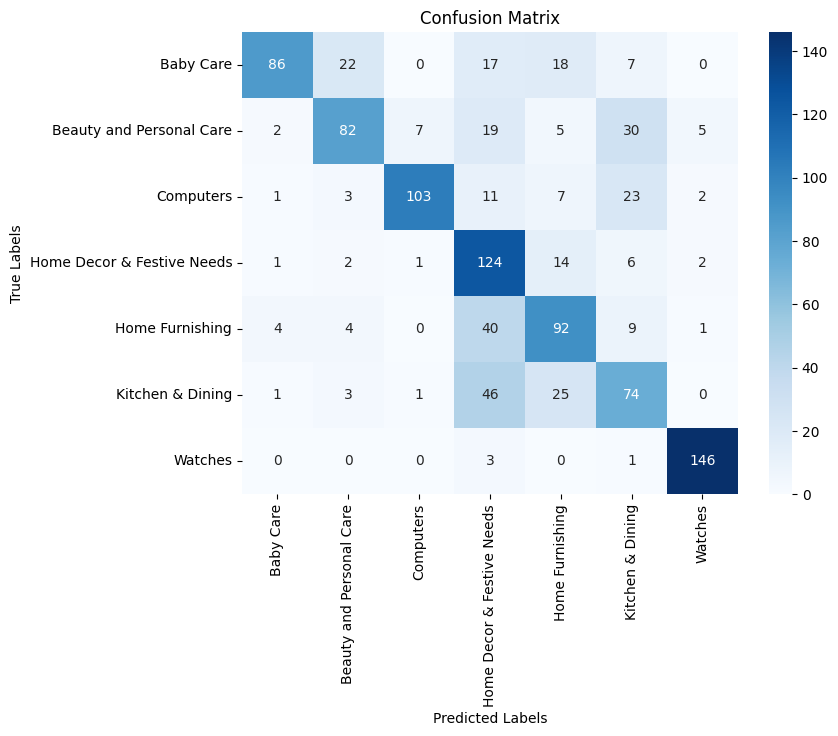

Classification Report:
                             precision    recall  f1-score   support

                 Baby Care       0.91      0.57      0.70       150
  Beauty and Personal Care       0.71      0.55      0.62       150
                 Computers       0.92      0.69      0.79       150
Home Decor & Festive Needs       0.48      0.83      0.60       150
           Home Furnishing       0.57      0.61      0.59       150
          Kitchen & Dining       0.49      0.49      0.49       150
                   Watches       0.94      0.97      0.95       150

                  accuracy                           0.67      1050
                 macro avg       0.72      0.67      0.68      1050
              weighted avg       0.72      0.67      0.68      1050



In [80]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Nettoyer les labels pour enlever les espaces en début et fin de chaîne
data_text['label'] = data_text['label'].str.strip()
data_text['label_phi3_corrected'] = data_text['label_phi3_corrected'].str.strip()

# Extraire les vraies étiquettes et les étiquettes prédites
true_labels = data_text['label']
predicted_labels = data_text['label_phi3_corrected']

# Obtenir les étiquettes uniques présentes dans true_labels
unique_labels = sorted(true_labels.unique())

# Générer la matrice de confusion
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=unique_labels)

# Convertir la matrice de confusion en DataFrame pour une meilleure visualisation
conf_matrix_df = pd.DataFrame(conf_matrix, index=unique_labels, columns=unique_labels)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

# Générer le rapport de classification
class_report = classification_report(true_labels, predicted_labels, target_names=unique_labels)

print("Classification Report:\n", class_report)


## génération des embeddings pour chaque description 

### test llama

In [21]:
from llama_cpp import Llama


llm = Llama(
  model_path="./Phi-3-mini-4k-instruct-q4.gguf",  # path to GGUF file
  n_ctx=4096,  # The max sequence length to use - note that longer sequence lengths require much more resources
  n_threads=8, # The number of CPU threads to use, tailor to your system and the resulting performance
  n_gpu_layers=0, # The number of layers to offload to GPU, if you have GPU acceleration available. Set to 0 if no GPU acceleration is available on your system.
)

prompt = "How to explain Internet to a medieval knight?"

# Simple inference example
output = llm(
  f"<|user|>\n{prompt}<|end|>\n<|assistant|>",
  max_tokens=256,  # Generate up to 256 tokens
  stop=["<|end|>"], 
  echo=True,  # Whether to echo the prompt
)

print(output['choices'][0]['text'])

llama_model_loader: loaded meta data with 24 key-value pairs and 195 tensors from ./Phi-3-mini-4k-instruct-q4.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = phi3
llama_model_loader: - kv   1:                               general.name str              = Phi3
llama_model_loader: - kv   2:                        phi3.context_length u32              = 4096
llama_model_loader: - kv   3:                      phi3.embedding_length u32              = 3072
llama_model_loader: - kv   4:                   phi3.feed_forward_length u32              = 8192
llama_model_loader: - kv   5:                           phi3.block_count u32              = 32
llama_model_loader: - kv   6:                  phi3.attention.head_count u32              = 32
llama_model_loader: - kv   7:               phi3.attention.head_count_kv u32         

<|user|>
How to explain Internet to a medieval knight?<|end|>
<|assistant|> Dear honorable Knight,

Allow me to describe this extraordinary realm known as the "Internet" in terms that align with your understanding of the world. Imagine it as an immense library that transcends physical boundaries and is accessible to all those who possess knowledge of its ways.

1. The Library of Babel (Analogy): In medieval times, great libraries housed vast collections of scrolls containing a wealth of information; similarly, the Internet serves as an endless repository of human thought, creations, and experiences. Just as librarians are tasked with organizing and cataloging books in a library, so too do people create directories called websites to help navigate this digital library efficiently.

2. The Pigeon Post System (Analogy): Traditionally, you would send messages using pigeons trained for communication purposes. In the Internet age, information travels instantaneously between distant lands thr

### test embeddings

In [22]:
import ollama

ollama.embeddings(
  model='phi3',
  prompt='Llamas are members of the camelid family',
)


{'embedding': [-1.353784441947937,
  0.33155351877212524,
  1.326086401939392,
  1.7937287092208862,
  0.04994022473692894,
  0.2754523754119873,
  -0.46001115441322327,
  0.9970048666000366,
  1.4271777868270874,
  1.6293697357177734,
  1.2750188112258911,
  -1.7145546674728394,
  -1.9012138843536377,
  0.435251921415329,
  -0.9386088848114014,
  -2.7997710704803467,
  -1.517596960067749,
  0.8663760423660278,
  -1.869368076324463,
  -1.209044098854065,
  2.449054002761841,
  -1.8805088996887207,
  2.7476918697357178,
  -1.1121233701705933,
  0.9710204601287842,
  1.3244879245758057,
  -3.2319741249084473,
  -1.0534478425979614,
  -0.5952792167663574,
  1.6801209449768066,
  2.0175492763519287,
  -1.2883217334747314,
  -1.3688619136810303,
  -1.4607888460159302,
  -1.1501299142837524,
  -1.6536877155303955,
  0.41757017374038696,
  -0.02670985646545887,
  0.9448819160461426,
  -0.6129662394523621,
  -1.3877516984939575,
  -0.7661215662956238,
  1.661283016204834,
  0.3323075771331787,

### obtention embeddings et enregistrement dans dataframe

In [23]:
# Fonction pour obtenir les embeddings
def get_phi3_embedding(description):
    response = ollama.embeddings(
        model='phi3',
        prompt=description
    )
    return response['embedding']

# Tester l'obtention d'un embedding pour une seule description
test_description = data_text['description'].iloc[0]
embedding = get_phi3_embedding(test_description)

# Afficher l'embedding obtenu
print(f"Description: {test_description}")
print(f"Embedding: {embedding}")


Description: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room

Il semble que la génération d'un embedding fonctionne. Généralisons la génération d'embeddings pour chaque items 

### test de barre de progression

In [24]:
import pandas as pd
from tqdm import tqdm
import time


# Assurez-vous que tqdm fonctionne bien avec pandas apply
tqdm.pandas()

# Fonction factice pour simuler le traitement
def dummy_function(description):
    time.sleep(0.1)  # Simule un temps de traitement
    return len(description)  # Retourne la longueur de la description comme valeur factice

# Appliquer la fonction factice à chaque description avec une barre de progression
data_text['dummy_result'] = data_text['description'].progress_apply(dummy_function)

# Afficher le DataFrame avec la nouvelle colonne
print(data_text)


100%|████████████████████████████████████████████████████████████████| 1050/1050 [01:45<00:00,  9.93it/s]

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                     image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            

### application de la génération d'embeddings à chaque item de data_text

In [25]:
# Assurez-vous que tqdm fonctionne bien avec pandas apply
tqdm.pandas()

# Fonction pour obtenir les embeddings
def get_phi3_embedding(description):
    response = ollama.embeddings(
        model='phi3',
        prompt=description
    )
    return response['embedding']

# Appliquer la fonction à chaque description avec une barre de progression
data_text['phi3_vector'] = data_text['description'].progress_apply(get_phi3_embedding)

# Afficher le DataFrame avec la nouvelle colonne
print(data_text)


100%|██████████████████████████████████████████████████████████████| 1050/1050 [1:10:34<00:00,  4.03s/it]

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                     image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            

### vérification des embeddings

In [26]:
data_text['phi3_vector'][0]

[-0.8196845650672913,
 0.9518484473228455,
 -0.8036758303642273,
 0.6631823778152466,
 1.020701289176941,
 0.8211438059806824,
 -1.8658483028411865,
 0.2360982596874237,
 1.109694242477417,
 1.960402250289917,
 -0.7657948732376099,
 0.40261945128440857,
 -1.5780870914459229,
 1.6980751752853394,
 0.5531371235847473,
 -0.2764184772968292,
 0.07639820873737335,
 0.5864699482917786,
 0.05240282788872719,
 -0.36423566937446594,
 -0.041874296963214874,
 -1.1961040496826172,
 0.3504089117050171,
 0.9769769310951233,
 -0.6422814726829529,
 0.33784565329551697,
 -0.5699508786201477,
 0.03111938387155533,
 -0.06700102984905243,
 0.46170052886009216,
 1.2710338830947876,
 -1.111660122871399,
 -0.09017005562782288,
 -0.03496450185775757,
 0.4251401126384735,
 -0.37865129113197327,
 0.21541450917720795,
 -0.46851515769958496,
 -0.677203893661499,
 -0.6043702363967896,
 0.3063890039920807,
 -0.9679726362228394,
 -0.2207719385623932,
 0.7794270515441895,
 -1.3222886323928833,
 0.5794249773025513,
 0

### Exploration visuelle des données 

In [15]:
# def display_info_and_image(row, image_folder='data/Images'):
#     # Construire le chemin complet de l'image
#     image_path = os.path.join(image_folder, row['image'])
    
#     # Vérifier si le fichier existe
#     if os.path.exists(image_path):
#         # Charger et afficher l'image
#         img = Image.open(image_path)
#         plt.imshow(img)
#         plt.axis('off')  # Masquer les axes
#         plt.title(f"Label: {row['label']}")
#         plt.show()
        
#         # Afficher les informations
#         print(f"Product: {row['description']}")
#         print(f"Label: {row['label']}")
#         print(f"Cleaned Description: {row['cleaned_description']}")
#         print(f"Stemmed Description: {row['stemmed_description']}")
#         print(f"Lemmatized Description: {row['lemmatized_description']}")
#     else:
#         print(f"L'image {image_path} n'existe pas.")


In [16]:
# # Afficher une image pour chaque label possible
# for label in data_text['label'].unique():
#     row = data_text[data_text['label'] == label].iloc[5]  # Prendre la première occurrence pour chaque label
#     display_info_and_image(row)


## Création des vecteurs

### Word2Vec

In [17]:
from gensim.models import Word2Vec

# Entraîner le modèle Word2Vec
w2v_model = Word2Vec(sentences=data_text['tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Générer les vecteurs Word2Vec
data_text['w2v_vector'] = data_text['tokens'].apply(lambda tokens: np.mean([w2v_model.wv[token] for token in tokens if token in w2v_model.wv], axis=0))


In [18]:
data_text

,product_name,image,description,label,label_encoded,tokens,w2v_vector
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4,"[key, feature, elegance, polyester, multicolor...","[-0.19074331, 0.23441087, 0.097070545, 0.26786..."
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0,"[specification, sathiyas, cotton, bath, towel,...","[-0.28218383, 0.22743888, 0.15305655, 0.362421..."
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,0,"[key, feature, eurospa, cotton, terry, face, t...","[-0.22889298, 0.29561123, 0.13588732, 0.317191..."
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,4,"[key, feature, santosh, royal, fashion, cotton...","[-0.20667306, 0.19261692, 0.05852556, 0.311636..."
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,4,"[key, feature, jaipur, print, cotton, floral, ...","[-0.22559059, 0.26246017, 0.08698234, 0.327823..."
...,...,...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care,0,"[oren, empower, extra, large, self, adhesive, ...","[-0.16275099, 0.25617984, 0.11853108, 0.204937..."
1046,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Baby Care,0,"[wallmantra, large, vinyl, sticker, sticker, p...","[-0.24029212, 0.3880271, 0.15667382, 0.3040173..."
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Baby Care,0,"[buy, uberlyfe, extra, large, pigmented, polyv...","[-0.26506552, 0.77484226, 0.27128392, 0.407380..."
1048,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Baby Care,0,"[buy, wallmantra, medium, vinyl, sticker, stic...","[-0.34124073, 0.9913547, 0.34550866, 0.52897, ..."


### BERT

In [19]:

# Charger le modèle et le tokenizer BERT
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(text):
    inputs = bert_tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Générer les vecteurs BERT
data_text['bert_vector'] = data_text['description'].apply(get_bert_embeddings)


In [20]:
data_text

,product_name,image,description,label,label_encoded,tokens,w2v_vector,bert_vector
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4,"[key, feature, elegance, polyester, multicolor...","[-0.19074331, 0.23441087, 0.097070545, 0.26786...","[[-0.03859947, -0.115220815, 0.53407776, -0.01..."
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0,"[specification, sathiyas, cotton, bath, towel,...","[-0.28218383, 0.22743888, 0.15305655, 0.362421...","[[-0.006365305, -0.21291882, 0.3860384, 0.1868..."
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,0,"[key, feature, eurospa, cotton, terry, face, t...","[-0.22889298, 0.29561123, 0.13588732, 0.317191...","[[-0.0821157, -0.095654294, 0.41026992, 0.0884..."
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,4,"[key, feature, santosh, royal, fashion, cotton...","[-0.20667306, 0.19261692, 0.05852556, 0.311636...","[[0.099828914, -0.099598154, 0.4847582, 0.0701..."
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,4,"[key, feature, jaipur, print, cotton, floral, ...","[-0.22559059, 0.26246017, 0.08698234, 0.327823...","[[-0.019337831, -0.048940413, 0.40272278, 0.06..."
...,...,...,...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care,0,"[oren, empower, extra, large, self, adhesive, ...","[-0.16275099, 0.25617984, 0.11853108, 0.204937...","[[-0.15966603, -0.02683936, 0.22889984, 0.0405..."
1046,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Baby Care,0,"[wallmantra, large, vinyl, sticker, sticker, p...","[-0.24029212, 0.3880271, 0.15667382, 0.3040173...","[[-0.09039575, -0.030846592, 0.44346017, 0.100..."
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Baby Care,0,"[buy, uberlyfe, extra, large, pigmented, polyv...","[-0.26506552, 0.77484226, 0.27128392, 0.407380...","[[0.24788663, -0.18012571, 0.4913336, 0.197208..."
1048,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Baby Care,0,"[buy, wallmantra, medium, vinyl, sticker, stic...","[-0.34124073, 0.9913547, 0.34550866, 0.52897, ...","[[0.20888926, -0.16934109, 0.5034506, 0.213345..."


### Universal Sentence Encoder

In [21]:
import tensorflow_hub as hub

# Désactiver l'utilisation du GPU par TensorFlow 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Charger le modèle Universal Sentence Encoder
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def get_use_embeddings(text):
    return use_model([text]).numpy().flatten()

# Générer les vecteurs USE
data_text['use_vector'] = data_text['description'].apply(get_use_embeddings)


2024-07-19 09:08:47.841205: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-19 09:08:47.841241: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: alexandre-desktop
2024-07-19 09:08:47.841247: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: alexandre-desktop
2024-07-19 09:08:47.841453: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 470.256.2
2024-07-19 09:08:47.841472: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 470.256.2
2024-07-19 09:08:47.841477: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 470.256.2


In [22]:
w2v_shape = data_text['w2v_vector'][0].shape
bert_shape = data_text['bert_vector'][0].shape
use_shape = data_text['use_vector'][0].shape

print(f"Word2Vec vector shape: {w2v_shape}\nBERT vector shape: {bert_shape}\nUniversal Sentence Encoder vector shape: {use_shape}")


Word2Vec vector shape: (100,)
BERT vector shape: (1, 768)
Universal Sentence Encoder vector shape: (512,)


## Réduction dimension et analyse

### Réduction PCA

In [23]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Fonction pour aplatir les vecteurs
def flatten_vectors(vectors):
    return np.array([vector.flatten() if isinstance(vector, np.ndarray) and vector.ndim > 1 else vector for vector in vectors])

# Assurez-vous que les vecteurs ne contiennent pas de NaN
data_text = data_text.dropna(subset=['w2v_vector', 'bert_vector', 'use_vector'])

# Aplatir les vecteurs et transformer en matrices 2D
w2v_matrix = flatten_vectors(data_text['w2v_vector'].tolist())
bert_matrix = flatten_vectors(data_text['bert_vector'].tolist())
use_matrix = flatten_vectors(data_text['use_vector'].tolist())

# Réaliser la PCA en conservant 99% de la variance
pca_w2v = PCA(n_components=0.99, svd_solver='full')
pca_bert = PCA(n_components=0.99, svd_solver='full')
pca_use = PCA(n_components=0.99, svd_solver='full')

w2v_reduced = pca_w2v.fit_transform(w2v_matrix)
bert_reduced = pca_bert.fit_transform(bert_matrix)
use_reduced = pca_use.fit_transform(use_matrix)

# Ajouter les vecteurs réduits au DataFrame
data_text['w2v_vector_reduced'] = list(w2v_reduced)
data_text['bert_vector_reduced'] = list(bert_reduced)
data_text['use_vector_reduced'] = list(use_reduced)

# Afficher les formes avant et après PCA
print(f"Word2Vec vector shape before PCA: {w2v_matrix.shape}")
print(f"Word2Vec vector shape after PCA: {w2v_reduced.shape}")

print(f"BERT vector shape before PCA: {bert_matrix.shape}")
print(f"BERT vector shape after PCA: {bert_reduced.shape}")

print(f"Universal Sentence Encoder vector shape before PCA: {use_matrix.shape}")
print(f"Universal Sentence Encoder vector shape after PCA: {use_reduced.shape}")


Word2Vec vector shape before PCA: (1050, 100)
Word2Vec vector shape after PCA: (1050, 4)
BERT vector shape before PCA: (1050, 768)
BERT vector shape after PCA: (1050, 254)
Universal Sentence Encoder vector shape before PCA: (1050, 512)
Universal Sentence Encoder vector shape after PCA: (1050, 308)


### réduction PCA phi3

In [27]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Fonction pour aplatir les vecteurs
def flatten_vectors(vectors):
    return np.array([vector.flatten() if isinstance(vector, np.ndarray) and vector.ndim > 1 else vector for vector in vectors])

# Assurez-vous que les vecteurs ne contiennent pas de NaN
data_text = data_text.dropna(subset=['phi3_vector'])

# Aplatir les vecteurs et transformer en matrices 2D
phi3_matrix = flatten_vectors(data_text['phi3_vector'].tolist())

# Réaliser la PCA en conservant 99% de la variance
pca_phi3 = PCA(n_components=0.99, svd_solver='full')

phi3_reduced = pca_phi3.fit_transform(phi3_matrix)

# Ajouter les vecteurs réduits au DataFrame
data_text['phi3_vector_reduced'] = list(phi3_reduced)

# Afficher les formes avant et après PCA
print(f"Phi3 vector shape before PCA: {phi3_matrix.shape}")
print(f"Phi3 vector shape after PCA: {phi3_reduced.shape}")


Phi3 vector shape before PCA: (1050, 3072)
Phi3 vector shape after PCA: (1050, 531)


### Réduction de dimension T-SNE et affichage des items selon vraies classes

In [24]:
# Heure de début de l'exécution de T-SNE
temps1 = time.time()

# Exécution de T-SNE
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)

# Application de T-SNE sur les données PCA pour obtenir la représentation en 2D
X_tsne_w2v = tsne.fit_transform(np.array(data_text['w2v_vector_reduced'].tolist()))
X_tsne_bert = tsne.fit_transform(np.array(data_text['bert_vector_reduced'].tolist()))
X_tsne_use = tsne.fit_transform(np.array(data_text['use_vector_reduced'].tolist()))

# Heure de fin de l'exécution et calcul du temps d'exécution
duration1 = time.time() - temps1
print("temps des 3 T-SNE : ", "%15.2f" % duration1, "secondes")

# Affichage de la forme des données après T-SNE pour vérification
print("Shape des données w2v après T-SNE:", X_tsne_w2v.shape)
print("Shape des données bert après T-SNE:", X_tsne_bert.shape)
print("Shape des données use après T-SNE:", X_tsne_use.shape)

temps des 3 T-SNE :             6.45 secondes
Shape des données w2v après T-SNE: (1050, 2)
Shape des données bert après T-SNE: (1050, 2)
Shape des données use après T-SNE: (1050, 2)


##### Réduction tsne pour phi3

In [28]:
import time
from sklearn import manifold
import numpy as np

# Heure de début de l'exécution de T-SNE
temps1 = time.time()

# Exécution de T-SNE
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)

# Application de T-SNE sur les données PCA pour obtenir la représentation en 2D
X_tsne_phi3 = tsne.fit_transform(np.array(data_text['phi3_vector_reduced'].tolist()))

# Heure de fin de l'exécution et calcul du temps d'exécution
duration1 = time.time() - temps1
print("temps du T-SNE pour phi3 : ", "%15.2f" % duration1, "secondes")

# Affichage de la forme des données après T-SNE pour vérification
print("Shape des données phi3 après T-SNE:", X_tsne_phi3.shape)

# Ajouter les vecteurs réduits par T-SNE au DataFrame
data_text['phi3_tsne'] = list(X_tsne_phi3)

# Afficher le DataFrame avec la nouvelle colonne
print(data_text)


temps du T-SNE pour phi3 :             2.04 secondes
Shape des données phi3 après T-SNE: (1050, 2)
                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                     image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4

#### affichage PHI3

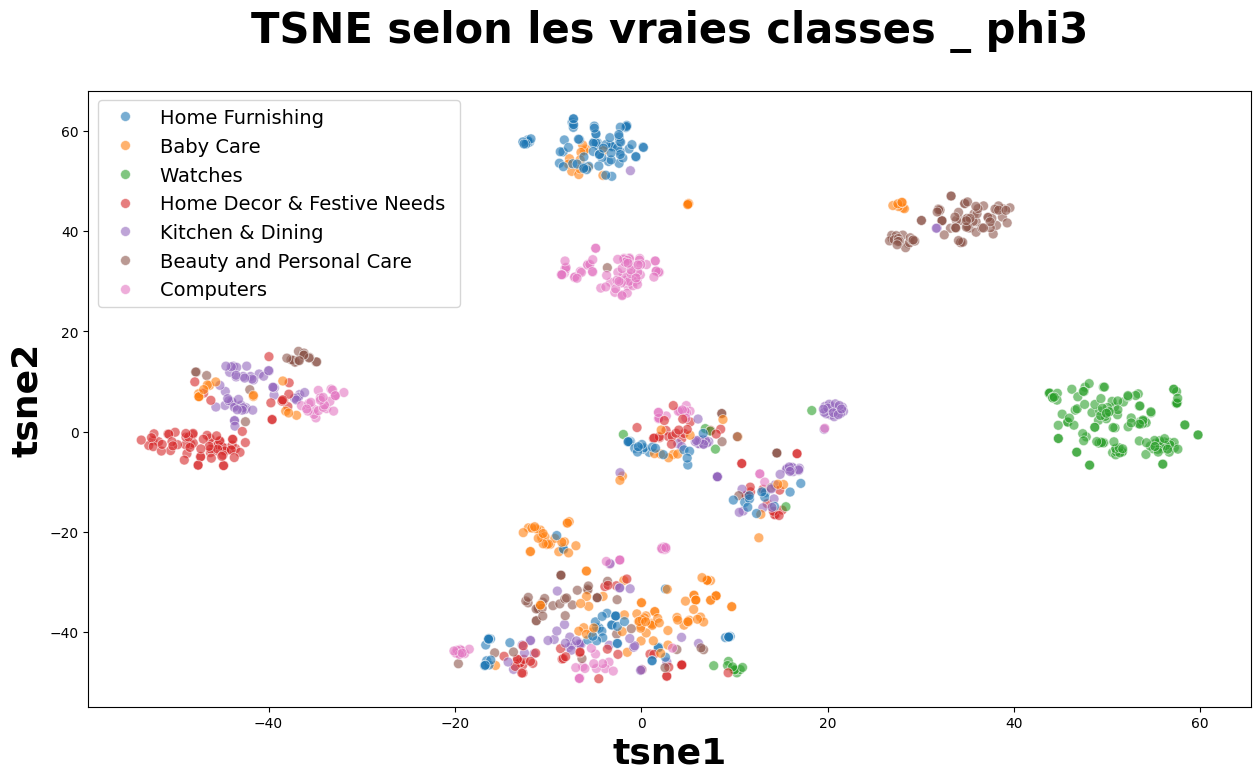

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que data_text contient déjà la colonne 'label'
# création dataframe pour affichage avec coordonnées tsne
df_tsne_phi3 = pd.DataFrame(X_tsne_phi3, columns=['tsne1', 'tsne2'])

# ajout colonne pour etiquette
df_tsne_phi3["class"] = data_text["label"]

# configuration figure
plt.figure(figsize=(15,8))

# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2", # définition des colonnes à utiliser pour les axes
    hue="class", # coloriage des points selon class
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # palette avec 7 couleurs, points de taille 50, 0.6 de transparence
    data=df_tsne_phi3, # source des données
    legend="brief" # légende succinte
)

# titres et labels
plt.title('TSNE selon les vraies classes _ phi3', fontsize = 30, pad = 35, fontweight = 'bold') # titre du graphique, paramètres de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # label axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # label axe y
plt.legend(prop={'size': 14}) # style légende

# affichage graphique
plt.show()


#### affichage W2V

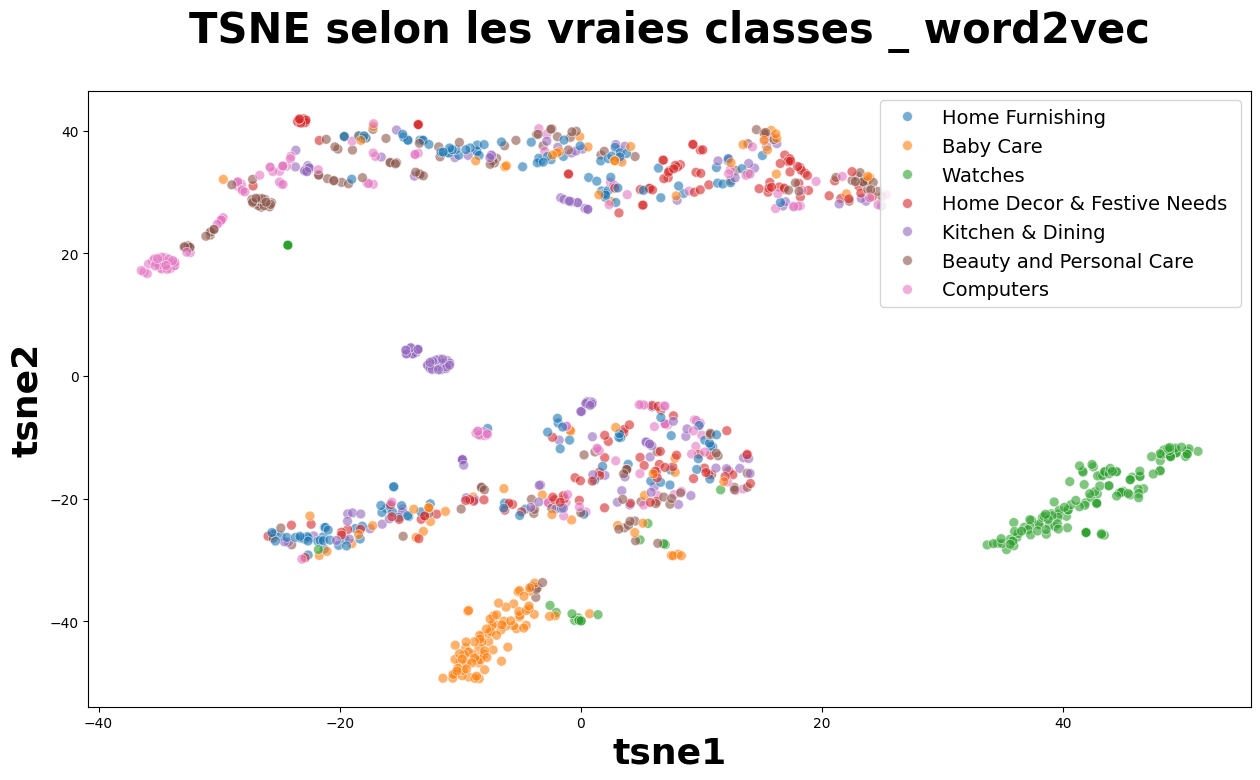

In [25]:
# création dataframe pour affichage avec coordonnées tsne
df_tsne_w2v = pd.DataFrame(X_tsne_w2v, columns=['tsne1', 'tsne2'])
# ajout colonne pour etiquette
df_tsne_w2v["class"] = data_text["label"]

# configuration figure
plt.figure(figsize=(15,8))

# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2",# définition des colonnes à utiliser pour les axes
    hue="class", # coloriage des points selon class
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # palette avec 4 couleurs, points de taille 50, 0.6 de transparence
    data=df_tsne_w2v, # source des données
    legend="brief") # légende succinte

# titres et labels
plt.title('TSNE selon les vraies classes _ word2vec', fontsize = 30, pad = 35, fontweight = 'bold') # titre du graphique, paramètres de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # label axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # label axe y
plt.legend(prop={'size': 14}) # style légende

# affichage graphique
plt.show()


#### affichage BERT

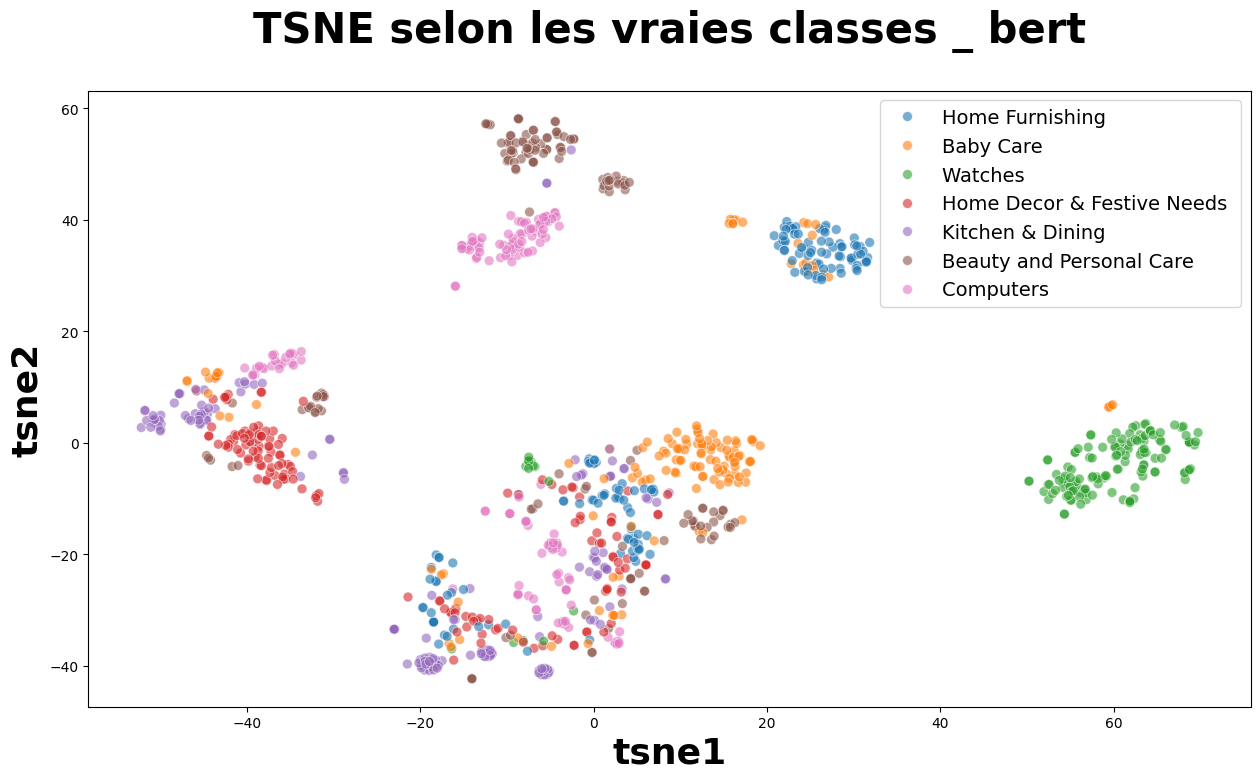

In [26]:
# création dataframe pour affichage avec coordonnées tsne
df_tsne_bert = pd.DataFrame(X_tsne_bert, columns=['tsne1', 'tsne2'])
# ajout colonne pour etiquette
df_tsne_bert["class"] = data_text["label"]

# configuration figure
plt.figure(figsize=(15,8))

# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2",# définition des colonnes à utiliser pour les axes
    hue="class", # coloriage des points selon class
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # palette avec 4 couleurs, points de taille 50, 0.6 de transparence
    data=df_tsne_bert, # source des données
    legend="brief") # légende succinte

# titres et labels
plt.title('TSNE selon les vraies classes _ bert', fontsize = 30, pad = 35, fontweight = 'bold') # titre du graphique, paramètres de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # label axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # label axe y
plt.legend(prop={'size': 14}) # style légende

# affichage graphique
plt.show()


#### affichage USE

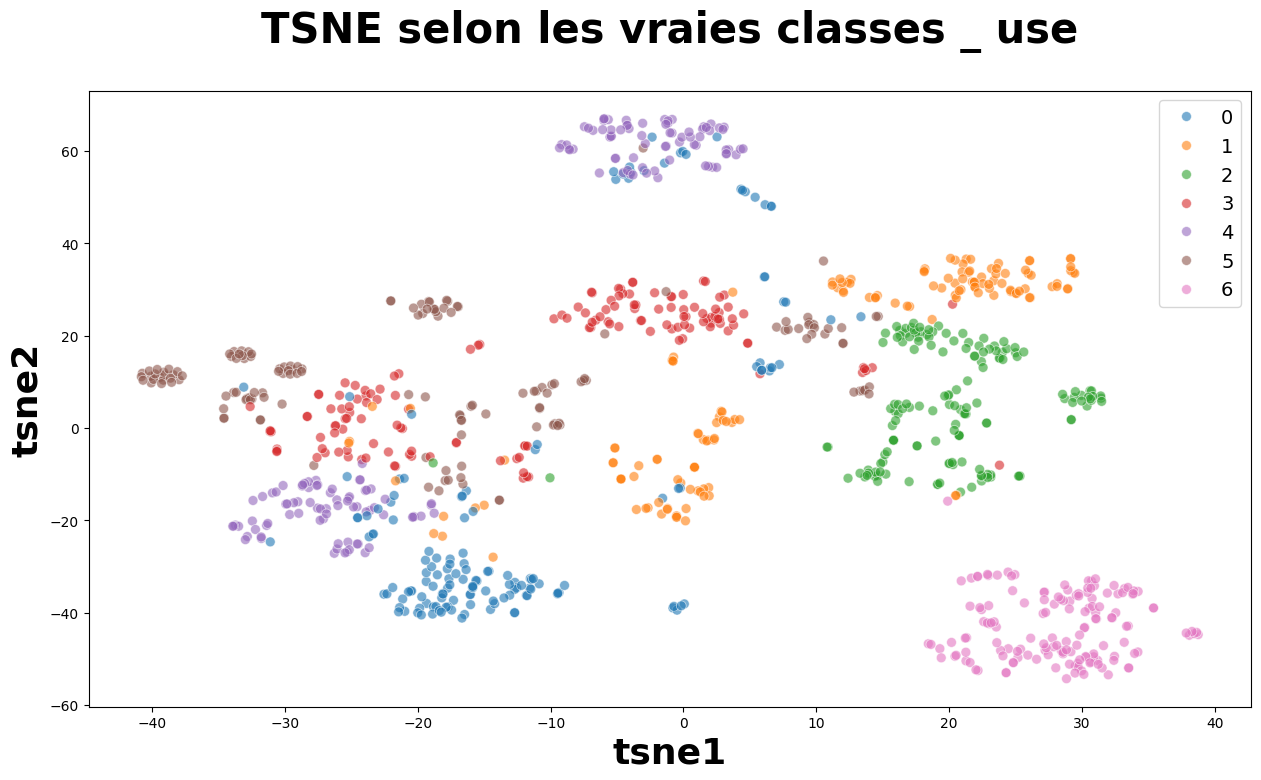

In [27]:
# création dataframe pour affichage avec coordonnées tsne
df_tsne_use = pd.DataFrame(X_tsne_use, columns=['tsne1', 'tsne2'])
# ajout colonne pour etiquette
df_tsne_use["class"] = data_text["label_encoded"]

# configuration figure
plt.figure(figsize=(15,8))

# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2",# définition des colonnes à utiliser pour les axes
    hue="class", # coloriage des points selon class
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # palette avec 4 couleurs, points de taille 50, 0.6 de transparence
    data=df_tsne_use, # source des données
    legend="brief") # légende succinte

# titres et labels
plt.title('TSNE selon les vraies classes _ use', fontsize = 30, pad = 35, fontweight = 'bold') # titre du graphique, paramètres de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # label axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # label axe y
plt.legend(prop={'size': 14}) # style légende

# affichage graphique
plt.show()


### Création de clusters à partir du T-SNE et affichage des items selon clusters


In [28]:
# import module clustering et métriques
from sklearn import cluster, metrics

# config module cls (4 clusters, et 100 fois avec centroides initiaux diff, recherche celui avec meilleure inertie)
cls_w2v = cluster.KMeans(n_clusters=7, n_init=100)
cls_bert = cluster.KMeans(n_clusters=7, n_init=100)
cls_use = cluster.KMeans(n_clusters=7, n_init=100)
# application kmeans aux données tSNE
cls_w2v.fit(X_tsne_w2v)
cls_bert.fit(X_tsne_bert)
cls_use.fit(X_tsne_use)

KMeans(n_clusters=7, n_init=100)

##### création de clusters à partir du TSNE pour PHI3

In [30]:
# import module clustering et métriques
from sklearn import cluster, metrics

# config module cls (7 clusters, et 100 fois avec centroides initiaux diff, recherche celui avec meilleure inertie)
cls_phi3 = cluster.KMeans(n_clusters=7, n_init=100)

# application kmeans aux données tSNE
cls_phi3.fit(X_tsne_phi3)

# obtenir les labels de clusters
phi3_labels = cls_phi3.labels_

# Ajouter les labels de clusters au DataFrame
data_text['phi3_cluster'] = phi3_labels

# Afficher les clusters obtenus
print(data_text[['description', 'phi3_cluster']])


                                            description  phi3_cluster
0     Key Features of Elegance Polyester Multicolor ...             0
1     Specifications of Sathiyas Cotton Bath Towel (...             0
2     Key Features of Eurospa Cotton Terry Face Towe...             0
3     Key Features of SANTOSH ROYAL FASHION Cotton P...             0
4     Key Features of Jaipur Print Cotton Floral Kin...             0
...                                                 ...           ...
1045  Oren Empower Extra Large Self Adhesive Sticker...             4
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...             4
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...             3
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...             3
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...             3

[1050 rows x 2 columns]


#### affichage PHI3

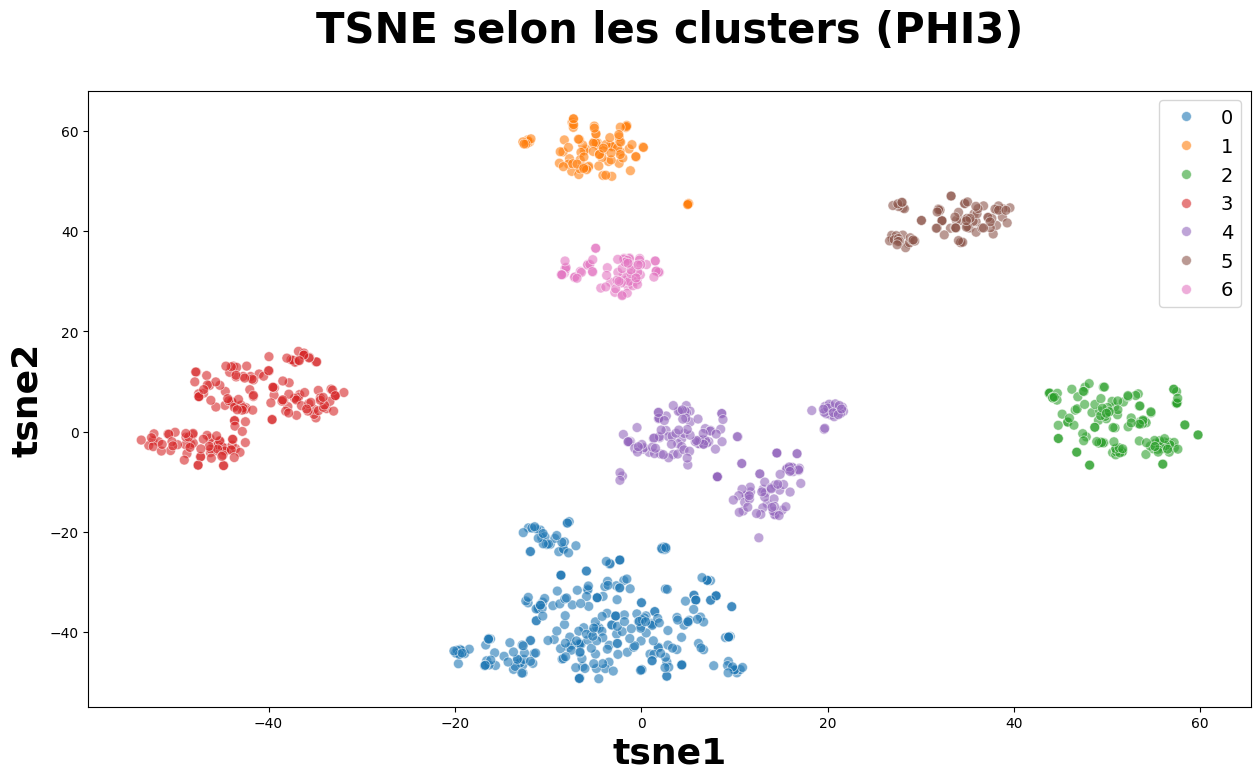

ARI (PHI3) :  0.2668064797459134


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Ajout des étiquettes de clusters à df_tsne_phi3
df_tsne_phi3 = pd.DataFrame(X_tsne_phi3, columns=['tsne1', 'tsne2'])
df_tsne_phi3["cluster"] = cls_phi3.labels_
df_tsne_phi3["class"] = data_text["label"]

# Configuration de la figure
plt.figure(figsize=(15,8))

# Création du graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2", # Sélection des données pour les axes x et y
    hue="cluster", # Coloriage des points en fonction des clusters
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # Palette 7 couleurs, points taille 50, transparence 0.6
    data=df_tsne_phi3, # Source des données pour le graphique
    legend="brief" # Légende succincte
)

# Titres et labels
plt.title('TSNE selon les clusters (PHI3)', fontsize = 30, pad = 35, fontweight = 'bold') # Titre, paramètres de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # Label axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # Label axe y
plt.legend(prop={'size': 14}) # Style légende

# Affichage du graphique
plt.show()

# Évaluation du clustering
labels = data_text["label"]
print("ARI (PHI3) : ", metrics.adjusted_rand_score(labels, cls_phi3.labels_))


#### affichage W2V

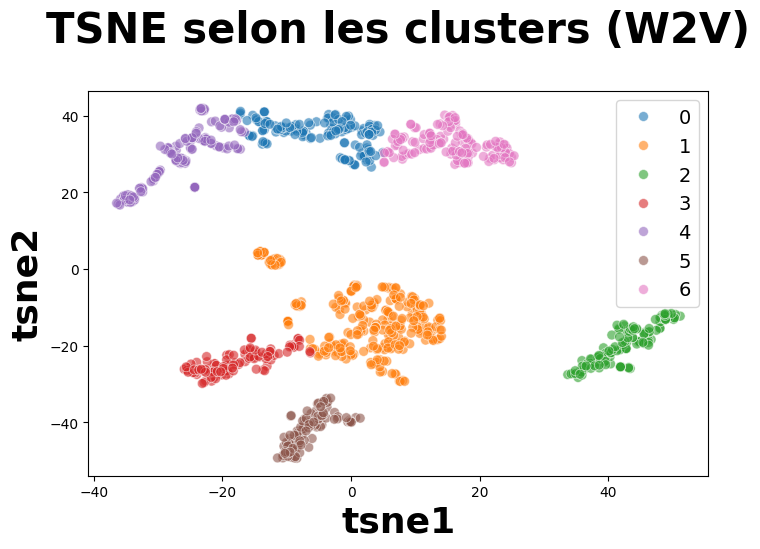

ARI (W2V) :  0.2175617381755061


In [29]:
#Visualisation des clusters
df_tsne_w2v["cluster"] = cls_w2v.labels_ # ajout etiquettes

# config figure
plt.figure(figsize=(8,5))
# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2", # selection des données pour axes x et y
    hue="cluster", # coloriage des points en fonction cluter
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # palette 7 couleurs, , points taille 50, transparence 0.6
    data=df_tsne_w2v, # source des données pour graph
    legend="brief") # légende succinte

# titres et labels
plt.title('TSNE selon les clusters (W2V)', fontsize = 30, pad = 35, fontweight = 'bold') # titre, paramètre de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # axe y
plt.legend(prop={'size': 14})  # style légende

# affichage graphique
plt.show()

# évaluation clustering
labels = data_text["label"]
print("ARI (W2V) : ", metrics.adjusted_rand_score(labels, cls_w2v.labels_))

#### affichage BERT

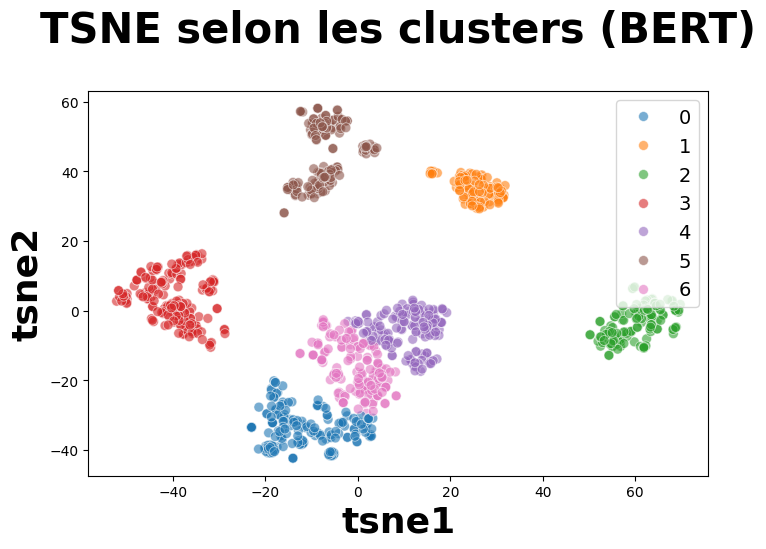

ARI (BERT) :  0.30364225119966826


In [30]:
#Visualisation des clusters
df_tsne_bert["cluster"] = cls_bert.labels_ # ajout etiquettes

# config figure
plt.figure(figsize=(8,5))
# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2", # selection des données pour axes x et y
    hue="cluster", # coloriage des points en fonction cluter
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # palette 7 couleurs, , points taille 50, transparence 0.6
    data=df_tsne_bert, # source des données pour graph
    legend="brief") # légende succinte

# titres et labels
plt.title('TSNE selon les clusters (BERT)', fontsize = 30, pad = 35, fontweight = 'bold') # titre, paramètre de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # axe y
plt.legend(prop={'size': 14})  # style légende

# affichage graphique
plt.show()

# évaluation clustering
labels = data_text["label"]
print("ARI (BERT) : ", metrics.adjusted_rand_score(labels, cls_bert.labels_))

#### affichage USE

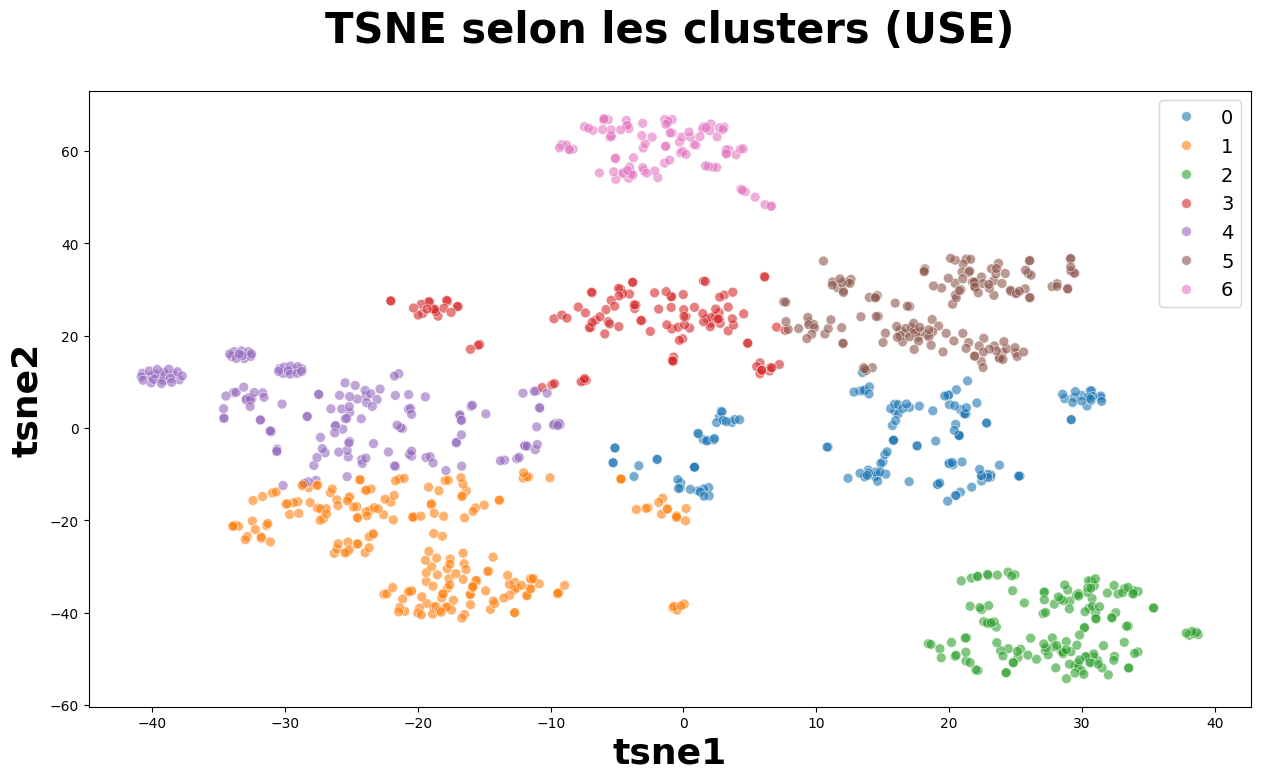

ARI (USE) :  0.4338623457335037


In [31]:
#Visualisation des clusters
df_tsne_use["cluster"] = cls_use.labels_ # ajout etiquettes

# config figure
plt.figure(figsize=(15,8))
# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2", # selection des données pour axes x et y
    hue="cluster", # coloriage des points en fonction cluter
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # palette 7 couleurs, , points taille 50, transparence 0.6
    data=df_tsne_use, # source des données pour graph
    legend="brief") # légende succinte

# titres et labels
plt.title('TSNE selon les clusters (USE)', fontsize = 30, pad = 35, fontweight = 'bold') # titre, paramètre de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # axe y
plt.legend(prop={'size': 14})  # style légende

# affichage graphique
plt.show()

# évaluation clustering
labels = data_text["label"]
print("ARI (USE) : ", metrics.adjusted_rand_score(labels, cls_use.labels_))

### Analyse par classes

#### w2v

In [32]:
# mAtrice de confusion
conf_mat_w2v = metrics.confusion_matrix(data_text['label_encoded'], cls_w2v.labels_) # calcul la matrice de confusion
print(conf_mat_w2v)# affichage matrice de confusion

[[ 15  19   0  14   6  83  13]
 [ 33  35   0   9  42   5  26]
 [ 11  53   0   3  63   0  20]
 [  8  53   0  21  12   0  56]
 [ 53  33   0  43   7   0  14]
 [ 26  84   0  15  11   0  14]
 [  0   5 128   1   6  10   0]]


In [34]:
# transformation de la matrice de confusion
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred) # calcul de la matrice de confusion
    
    corresp = np.argmax(conf_mat, axis=0) # trouve la correspondance des clusters
    print ("Correspondance des clusters : ", corresp)# affiche la correspondance
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame() # création d'un dataframe avec etiquettes reelles
    labels['y_pred'] = y_pred # ajoute etiquettes predites
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) # transforme etiquettes predites avec correspondance trouvée
    
    return labels['y_pred_transform'] # renvoie les etiquettes transformées

In [34]:
# application de la transformation et evaluation
cls_w2v_labels_transform = conf_mat_transform(data_text['label_encoded'], cls_w2v.labels_) # applique la fonction de transformation aux etiquettes des clusters
conf_mat_w2v = metrics.confusion_matrix(data_text['label_encoded'], cls_w2v_labels_transform) # calcule la nouvelle matrice de confustion avec les etiquettes transformées
print(conf_mat_w2v) # affiche la matrice de confusion
print()
print(metrics.classification_report(data_text['label_encoded'], cls_w2v_labels_transform)) # affiche rapport de classification détaillé (avec précision, rappel et score F1 pour chaque classe)

Correspondance des clusters :  [4 5 6 4 2 0 3]
[[ 83   0   6  13  29  19   0]
 [  5   0  42  26  42  35   0]
 [  0   0  63  20  14  53   0]
 [  0   0  12  56  29  53   0]
 [  0   0   7  14  96  33   0]
 [  0   0  11  14  41  84   0]
 [ 10   0   6   0   1   5 128]]

              precision    recall  f1-score   support

           0       0.85      0.55      0.67       150
           1       0.00      0.00      0.00       150
           2       0.43      0.42      0.42       150
           3       0.39      0.37      0.38       150
           4       0.38      0.64      0.48       150
           5       0.30      0.56      0.39       150
           6       1.00      0.85      0.92       150

    accuracy                           0.49      1050
   macro avg       0.48      0.49      0.47      1050
weighted avg       0.48      0.49      0.47      1050



/home/alexandre/anaconda3/envs/stabadenvP6/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/anaconda3/envs/stabadenvP6/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/anaconda3/envs/stabadenvP6/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

<Axes: >

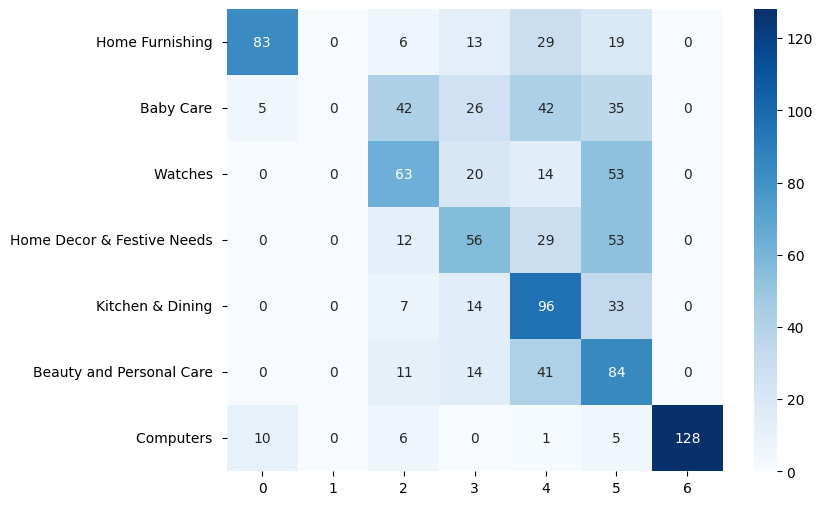

In [35]:
list_labels = ['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers ']

df_cm = pd.DataFrame(conf_mat_w2v, index = [label for label in list_labels],
                  columns = [i for i in "0123456"]) # création dataframe a partir matrice conf avec labels en index et les colonnes
plt.figure(figsize = (8,6)) # configuration de la taille de la figure
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d') # créé une jolie heatmap

#### bert

In [36]:
# mAtrice de confusion
conf_mat_bert = metrics.confusion_matrix(data_text['label_encoded'], cls_bert.labels_) # calcul la matrice de confusion
print(conf_mat_bert)# affichage matrice de confusion

[[ 15  20   5  14  90   0   6]
 [  9   0   0  21  24  80  16]
 [ 24   0   0  24   0  70  32]
 [ 33   0   0  81   4   0  32]
 [ 27  74   0   0  17   0  32]
 [ 61   0   0  52  12   3  22]
 [  5   0 135   0   0   0  10]]


In [37]:
# application de la transformation et evaluation
cls_bert_labels_transform = conf_mat_transform(data_text['label_encoded'], cls_bert.labels_) # applique la fonction de transformation aux etiquettes des clusters
conf_mat_bert = metrics.confusion_matrix(data_text['label_encoded'], cls_bert_labels_transform) # calcule la nouvelle matrice de confustion avec les etiquettes transformées
print(conf_mat_bert) # affiche la matrice de confusion
print()
print(metrics.classification_report(data_text['label_encoded'], cls_bert_labels_transform)) # affiche rapport de classification détaillé (avec précision, rappel et score F1 pour chaque classe)

Correspondance des clusters :  [5 4 6 3 0 1 2]
[[ 90   0   6  14  20  15   5]
 [ 24  80  16  21   0   9   0]
 [  0  70  32  24   0  24   0]
 [  4   0  32  81   0  33   0]
 [ 17   0  32   0  74  27   0]
 [ 12   3  22  52   0  61   0]
 [  0   0  10   0   0   5 135]]

              precision    recall  f1-score   support

           0       0.61      0.60      0.61       150
           1       0.52      0.53      0.53       150
           2       0.21      0.21      0.21       150
           3       0.42      0.54      0.47       150
           4       0.79      0.49      0.61       150
           5       0.35      0.41      0.38       150
           6       0.96      0.90      0.93       150

    accuracy                           0.53      1050
   macro avg       0.55      0.53      0.53      1050
weighted avg       0.55      0.53      0.53      1050



<Axes: >

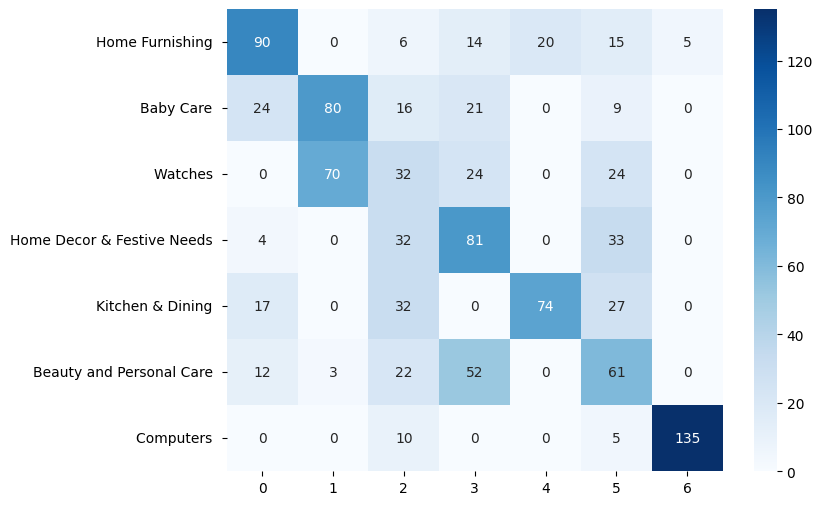

In [38]:
list_labels = ['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers ']

df_cm = pd.DataFrame(conf_mat_bert, index = [label for label in list_labels],
                  columns = [i for i in "0123456"]) # création dataframe a partir matrice conf avec labels en index et les colonnes
plt.figure(figsize = (8,6)) # configuration de la taille de la figure
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d') # créé une jolie heatmap

#### use

In [39]:
# mAtrice de confusion
conf_mat_use = metrics.confusion_matrix(data_text['label_encoded'], cls_use.labels_) # calcul la matrice de confusion
print(conf_mat_use)# affichage matrice de confusion

[[  2 108   0  10   6   4  20]
 [ 38  22   0   5   5  80   0]
 [ 97   1   0   0   1  51   0]
 [  2   4   0  75  64   5   0]
 [  0  71   0   0   5   0  74]
 [  6   8   0  30  87  18   1]
 [  1   0 149   0   0   0   0]]


In [40]:
# application de la transformation et evaluation
cls_use_labels_transform = conf_mat_transform(data_text['label_encoded'], cls_use.labels_) # applique la fonction de transformation aux etiquettes des clusters
conf_mat_use = metrics.confusion_matrix(data_text['label_encoded'], cls_use_labels_transform) # calcule la nouvelle matrice de confustion avec les etiquettes transformées
print(conf_mat_use) # affiche la matrice de confusion
print()
print(metrics.classification_report(data_text['label_encoded'], cls_use_labels_transform)) # affiche rapport de classification détaillé (avec précision, rappel et score F1 pour chaque classe)

Correspondance des clusters :  [2 0 6 3 5 1 4]
[[108   4   2  10  20   6   0]
 [ 22  80  38   5   0   5   0]
 [  1  51  97   0   0   1   0]
 [  4   5   2  75   0  64   0]
 [ 71   0   0   0  74   5   0]
 [  8  18   6  30   1  87   0]
 [  0   0   1   0   0   0 149]]

              precision    recall  f1-score   support

           0       0.50      0.72      0.59       150
           1       0.51      0.53      0.52       150
           2       0.66      0.65      0.66       150
           3       0.62      0.50      0.56       150
           4       0.78      0.49      0.60       150
           5       0.52      0.58      0.55       150
           6       1.00      0.99      1.00       150

    accuracy                           0.64      1050
   macro avg       0.66      0.64      0.64      1050
weighted avg       0.66      0.64      0.64      1050



<Axes: >

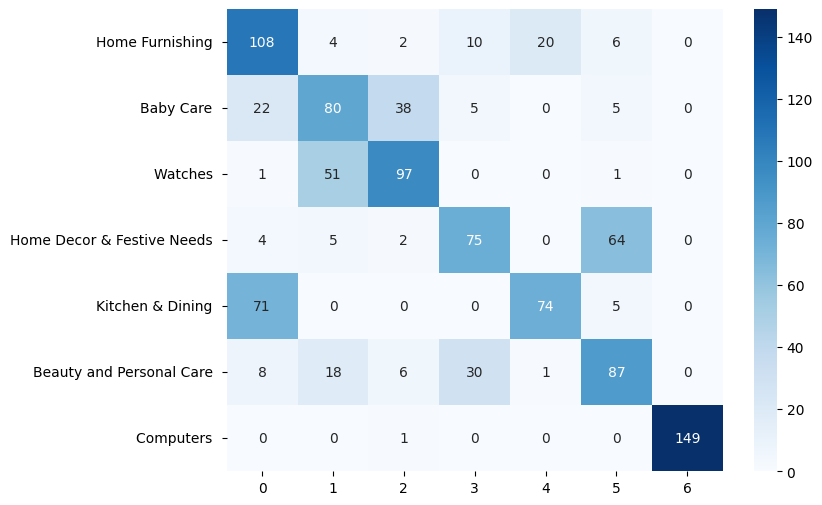

In [41]:
list_labels = ['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers ']

df_cm = pd.DataFrame(conf_mat_use, index = [label for label in list_labels],
                  columns = [i for i in "0123456"]) # création dataframe a partir matrice conf avec labels en index et les colonnes
plt.figure(figsize = (8,6)) # configuration de la taille de la figure
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d') # créé une jolie heatmap

#### phi3

In [32]:
# Matrice de confusion
conf_mat_phi3 = metrics.confusion_matrix(data_text['label_encoded'], cls_phi3.labels_) # Calcul de la matrice de confusion
print(conf_mat_phi3) # Affichage de la matrice de confusion


[[ 96  18   0  14  15   7   0]
 [ 40   0   0  21   9  79   1]
 [ 38   0   0  24  18   0  70]
 [ 37   0   0  76  37   0   0]
 [ 45  74   0   0  31   0   0]
 [ 36   1   0  48  63   2   0]
 [ 10   0 134   0   6   0   0]]


In [35]:
# Application de la transformation et évaluation
cls_phi3_labels_transform = conf_mat_transform(data_text['label_encoded'], cls_phi3.labels_) # Applique la fonction de transformation aux étiquettes des clusters
conf_mat_phi3 = metrics.confusion_matrix(data_text['label_encoded'], cls_phi3_labels_transform) # Calcule la nouvelle matrice de confusion avec les étiquettes transformées
print(conf_mat_phi3) # Affiche la matrice de confusion
print()
print(metrics.classification_report(data_text['label_encoded'], cls_phi3_labels_transform)) # Affiche le rapport de classification détaillé (avec précision, rappel et score F1 pour chaque classe)


Correspondance des clusters :  [0 4 6 3 5 1 2]
[[ 96   7   0  14  18  15   0]
 [ 40  79   1  21   0   9   0]
 [ 38   0  70  24   0  18   0]
 [ 37   0   0  76   0  37   0]
 [ 45   0   0   0  74  31   0]
 [ 36   2   0  48   1  63   0]
 [ 10   0   0   0   0   6 134]]

              precision    recall  f1-score   support

           0       0.32      0.64      0.42       150
           1       0.90      0.53      0.66       150
           2       0.99      0.47      0.63       150
           3       0.42      0.51      0.46       150
           4       0.80      0.49      0.61       150
           5       0.35      0.42      0.38       150
           6       1.00      0.89      0.94       150

    accuracy                           0.56      1050
   macro avg       0.68      0.56      0.59      1050
weighted avg       0.68      0.56      0.59      1050



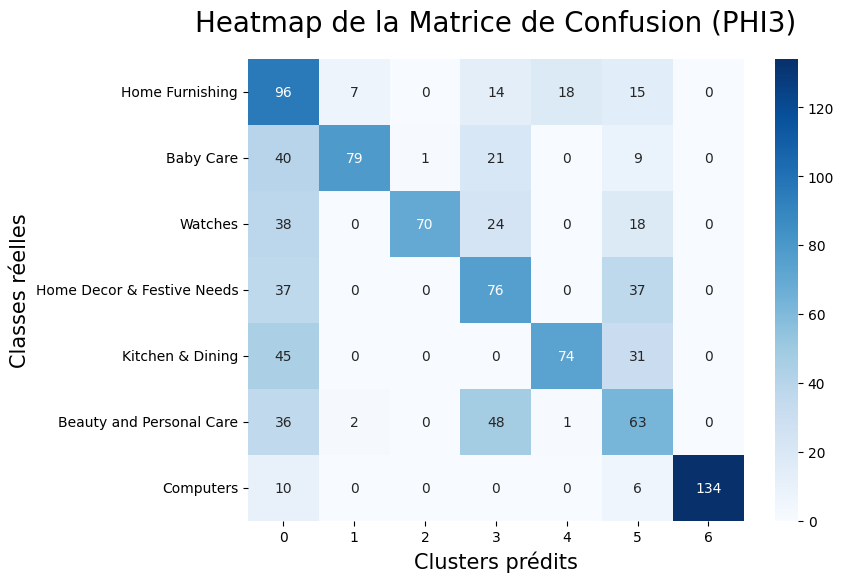

In [36]:
list_labels = ['Home Furnishing', 'Baby Care', 'Watches',
               'Home Decor & Festive Needs', 'Kitchen & Dining',
               'Beauty and Personal Care', 'Computers']

df_cm = pd.DataFrame(conf_mat_phi3, index = [label for label in list_labels],
                     columns = [i for i in "0123456"]) # Création du dataframe à partir de la matrice de confusion avec labels en index et les colonnes
plt.figure(figsize=(8,6)) # Configuration de la taille de la figure
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d') # Création d'une jolie heatmap
plt.title('Heatmap de la Matrice de Confusion (PHI3)', fontsize=20, pad=20)
plt.xlabel('Clusters prédits', fontsize=15)
plt.ylabel('Classes réelles', fontsize=15)
plt.show()
